PART-1 KNN IMPLEMENTATION

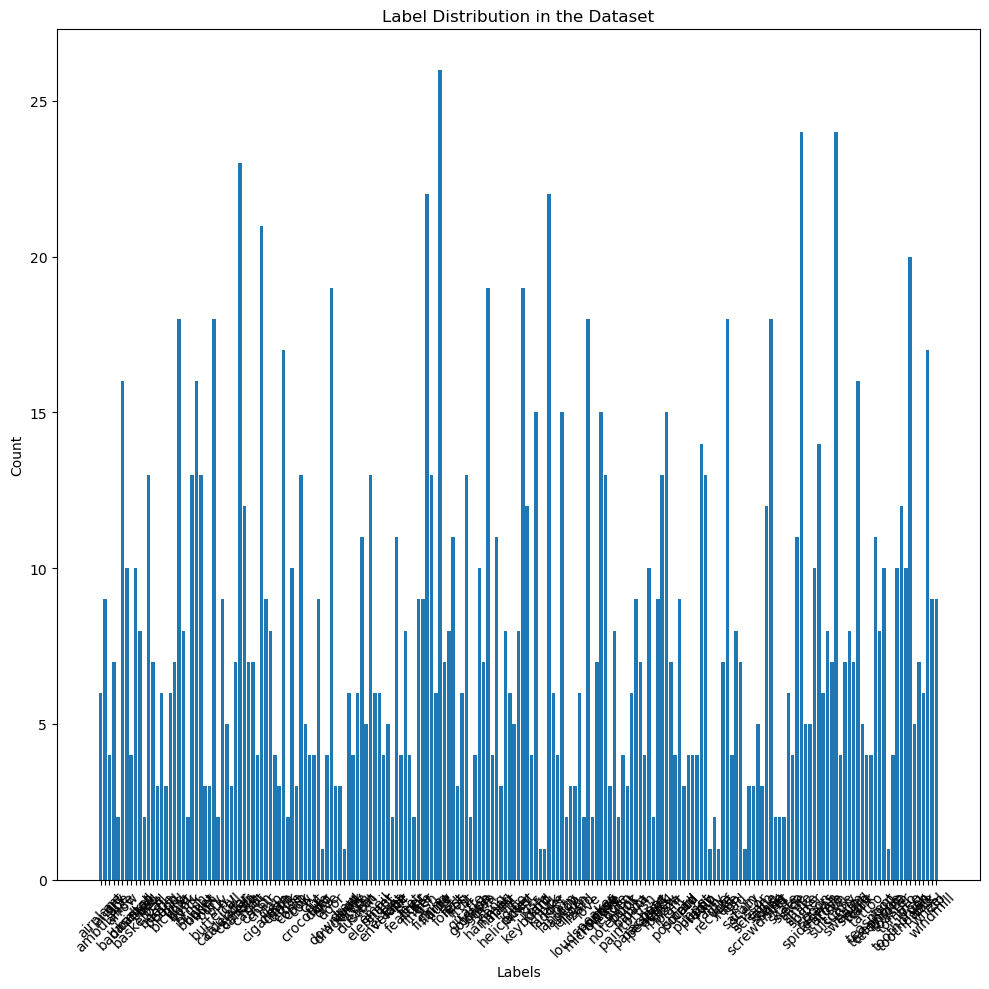

In [2]:
#Below is completed 2.2.1 Task 1

 #Import the necessary library - numpy
import numpy as np

#Import the necessary library - matplotlib to plot the graph
import matplotlib.pyplot as plt

import os

# Load the dataset from the .npy file
def load_dataset(filepath):
    """
    Load the dataset from a given .npy file.
    
    Args:
    - filepath (str): Path to the .npy file.
    
    Returns:
    - np.array: Loaded data from the .npy file.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"The file {filepath} does not exist.")
    
    try:
        return np.load(filepath, allow_pickle=True)
    #allow_pickle=True to remove the ValueError which is "ValueError: Cannot load file containing pickled data when allow_pickle=False"

    except Exception as e:
        raise RuntimeError(f"Error loading the dataset: {e}")

def get_label_distribution(data):
    """
    Extract the label distribution from the dataset.
    
    Args:
    - data (np.array): Loaded dataset.
    
    Returns:
    - tuple: (unique labels, counts for each label)
    """

    # Extract the label information from the dataset
    labels = data[:, 3]  # Assuming the label column is at index 3

    # Count the occurrences of each label
    return np.unique(labels, return_counts=True)

def plot_label_distribution(unique_labels, label_counts):
    """
    Plot the label distribution using a bar graph.
    
    Args:
    - unique_labels (np.array): Unique labels in the dataset.
    - label_counts (np.array): Counts for each label.
    """

    # Create a bar graph to visualize the label distribution
    plt.figure(figsize=(10, 10))
    plt.bar(unique_labels, label_counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution in the Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    filepath = 'data.npy'
    data = load_dataset(filepath)
    unique_labels, label_counts = get_label_distribution(data)
    plot_label_distribution(unique_labels, label_counts)


Checking some basic structure of the dataset for KNN implementation

In [3]:
print(data.shape)  #Shape is number of outermost entries

(1500, 5)


So n=1500, thus when we will do hypertuning, it will be under root of n, that is (n)^(1/2)

In [4]:
print(data.size) #Checking the size

7500


In [5]:
print(data.ndim)  #Dimension of data

2


In [6]:
# Below is the implementation of Task 2.3.1

#Import the necessary libraries

import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# KNN Class Definition (Subtask 1)
class KNN:
    def __init__(self, k=3, encoder_type="resnet", distance_metric="euclidean"):
        self.k = k
        self.encoder_type = encoder_type
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None
        self.label_to_int = {}
        self.int_to_label = {}

#Define all the distances
    
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def _manhattan_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2))
    
    def _cosine_distance(self, x1, x2):
        dot_product = np.dot(x1, x2)
        norm_x1 = np.linalg.norm(x1)
        norm_x2 = np.linalg.norm(x2)
        return 1 - (dot_product / (norm_x1 * norm_x2))
    
    def _hamming_distance(self, x1, x2):
        return np.sum(x1 != x2)
    
    def _minkowski_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2) ** self.p) ** (1 / self.p)
    
    def fit(self, X, y):
        unique_labels = np.unique(y)
        self.label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        self.int_to_label = {idx: label for label, idx in self.label_to_int.items()}
        y_int = np.array([self.label_to_int[label] for label in y])
        self.X_train = X
        self.y_train = y_int
    
    def predict(self, X):
        y_pred_int = [self._predict(x) for x in X]
        y_pred = [self.int_to_label[y_int] for y_int in y_pred_int]
        return np.array(y_pred)
    
    def _predict(self, x):
        # Compute distances based on the metric
        if self.distance_metric == "euclidean":
            distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "manhattan":
            distances = [self._manhattan_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "cosine":
            distances = [self._cosine_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "hamming":
            distances = [self._hamming_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "minkowski":
            distances = [self._minkowski_distance(x, x_train) for x_train in self.X_train]
        else:
            raise ValueError("Invalid distance metric.")
        
        # Get the indices of the k smallest distances
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Majority vote
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common
    
    def evaluate(self, X, y):
        y_pred = self.predict(X) #Returning predict (Subtask 2)
        f1 = f1_score(y, y_pred, average='macro')
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average='macro')
        recall = recall_score(y, y_pred, average='macro')
        
        return {"f1_score": f1, "accuracy": accuracy, "precision": precision, "recall": recall}

    def train_val_evaluate(self, X_train, y_train, X_val, y_val):
        self.fit(X_train, y_train)
        return self.evaluate(X_val, y_val)

# Load the data
data = np.load('data.npy', allow_pickle=True)

# Extract features and labels from the first 1500 rows
X_resnet = data[:1500, 1]
X_vit = data[:1500, 2]
y = data[:1500, 3]

# Convert 1D arrays of 2D arrays into proper 2D arrays
X_resnet_2D = np.vstack(X_resnet).reshape(-1, 1024)
X_vit_2D = np.vstack(X_vit).reshape(-1, 512)

# Concatenate along the second axis to create a single feature vector
X_combined = np.hstack([X_resnet_2D, X_vit_2D])

# Perform a single train-validation split
X_train_combined, X_val_combined, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Deconvolute the combined features back into ResNet and ViT features for individual use, if needed
X_train_resnet = X_train_combined[:, :1024]
X_train_vit = X_train_combined[:, 1024:]

X_val_resnet = X_val_combined[:, :1024]
X_val_vit = X_val_combined[:, 1024:]

# Initialize the KNN class
knn_instance = KNN(k=3, encoder_type='resnet', distance_metric='euclidean')

# Train and evaluate
evaluation_results = knn_instance.train_val_evaluate(X_train_combined, y_train, X_val_combined, y_val)
print("Evaluation Results:", evaluation_results)

# Initialize the KNN class
knn_instance = KNN(k=3, encoder_type='vit', distance_metric='euclidean')

# Train and evaluate
evaluation_results = knn_instance.train_val_evaluate(X_train_combined, y_train, X_val_combined, y_val)
print("Evaluation Results:", evaluation_results)

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Results: {'f1_score': 0.1203463611551847, 'accuracy': 0.22333333333333333, 'precision': 0.12583111333111333, 'recall': 0.15112942612942612}
Evaluation Results: {'f1_score': 0.1203463611551847, 'accuracy': 0.22333333333333333, 'precision': 0.12583111333111333, 'recall': 0.15112942612942612}


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
print("Shape of X_resnet:", np.shape(X_resnet))
print("Shape of X_vit:", np.shape(X_vit))

#For checking if resnet and vit have same shape or not


Shape of X_resnet: (1500,)
Shape of X_vit: (1500,)


Hyperparameter tuning is the process of systematically searching for the best combination of hyperparameters that optimizes a model's performance for a particular task.

In machine learning, a model's configuration is determined by both its parameters and its hyperparameters. Here's the distinction between the two:

Parameters: These are the parts of the model that are learned from the training data. For instance, in a linear regression model, the coefficients are parameters. In a neural network, the weights and biases are parameters.

Hyperparameters: These are the settings or knobs you can tweak before training a model. They are not learned from the data but rather are set beforehand. Examples include the learning rate in many optimization algorithms, the depth of a decision tree, the number of hidden layers in a neural network, or the 

k in K-Nearest Neighbors.
Hyperparameter tuning aims to find the hyperparameters that yield the best performance, as measured on a validation set. This can be done in several ways:

1. Grid Search: This involves exhaustively testing a predefined set of hyperparameters. For instance, for KNN, you might try k values of 1, 2, 3, ..., 10 and measure performance for each.

2. Random Search: Instead of trying every possible combination, random combinations of hyperparameters are tried. This can be faster and, surprisingly, often finds better or equivalent hyperparameters compared to grid search.

3. Bayesian Optimization: This is a more sophisticated method that builds a probabilistic model of the function mapping from hyperparameters to a validation score, and chooses new hyperparameters to try based on this model.

4. Gradient-based optimization: This method computes gradients with respect to hyperparameters and moves in the direction that improves them. This is mainly used for neural networks.

5. Evolutionary Algorithms: These algorithms mimic the process of natural selection to search for better hyperparameters.

Hyperparameter tuning can be computationally expensive because each set of hyperparameters requires training a new model. Thus, techniques like early stopping (for iterative algorithms like gradient descent) can be very beneficial.

In the context of your KNN implementation, hyperparameters could include:

The number of neighbors (

k).
The type of distance metric (Euclidean, Manhattan, Cosine, etc.).
The encoder type (ResNet, ViT, etc.).
Any weighting schemes for neighbors.
It's essential to remember that hyperparameter tuning should be done using a separate validation set or cross-validation to avoid overfitting to the training data. Once the best hyperparameters are found, the final model performance should be tested on a separate test set.

Top 20 (k, encoder, distance metric) combinations based on validation accuracy:
1. Accuracy: 0.3077, k: 1, Encoder: resnet, Distance: manhattan
2. Accuracy: 0.3077, k: 1, Encoder: vit, Distance: manhattan
3. Accuracy: 0.3043, k: 1, Encoder: resnet, Distance: euclidean
4. Accuracy: 0.3043, k: 1, Encoder: vit, Distance: euclidean
5. Accuracy: 0.3010, k: 9, Encoder: resnet, Distance: manhattan
6. Accuracy: 0.3010, k: 9, Encoder: vit, Distance: manhattan
7. Accuracy: 0.3010, k: 10, Encoder: resnet, Distance: manhattan
8. Accuracy: 0.3010, k: 10, Encoder: vit, Distance: manhattan
9. Accuracy: 0.2977, k: 1, Encoder: resnet, Distance: cosine
10. Accuracy: 0.2977, k: 1, Encoder: vit, Distance: cosine
11. Accuracy: 0.2977, k: 1, Encoder: resnet, Distance: minkowski
12. Accuracy: 0.2977, k: 1, Encoder: vit, Distance: minkowski
13. Accuracy: 0.2977, k: 8, Encoder: resnet, Distance: manhattan
14. Accuracy: 0.2977, k: 8, Encoder: vit, Distance: manhattan
15. Accuracy: 0.2943, k: 6, Encoder: resnet,

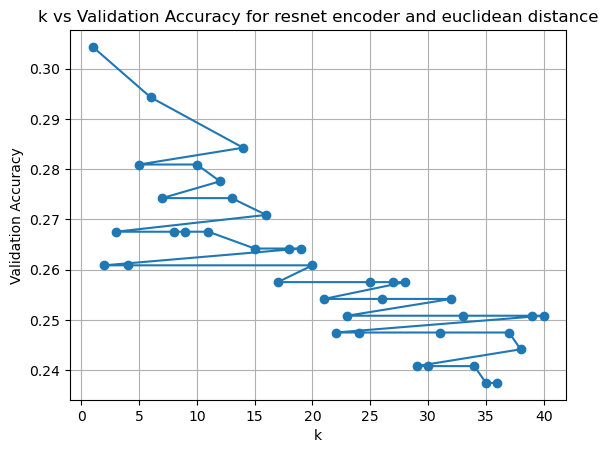

In [8]:
#Below is the implementation of 2.4.1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from collections import Counter

# KNN Class Definition
class KNN:
    def __init__(self, k=3, encoder_type="resnet", distance_metric="euclidean"):
        self.k = k
        self.encoder_type = encoder_type
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None
        self.label_to_int = {}
        self.int_to_label = {}

#Define the distances

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def _manhattan_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2))
    
    def _cosine_distance(self, x1, x2):
        dot_product = np.dot(x1, x2)
        norm_x1 = np.linalg.norm(x1)
        norm_x2 = np.linalg.norm(x2)
        return 1 - (dot_product / (norm_x1 * norm_x2))
    
    def _hamming_distance(self, x1, x2):
        return np.sum(x1 != x2)
    
    def _minkowski_distance(self, x1, x2, p=3):
        return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)
    
    def fit(self, X, y):
        unique_labels = np.unique(y)
        self.label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        self.int_to_label = {idx: label for label, idx in self.label_to_int.items()}
        y_int = np.array([self.label_to_int[label] for label in y])
        self.X_train = X
        self.y_train = y_int
    
    def predict(self, X):
        y_pred_int = [self._predict(x) for x in X]
        y_pred = [self.int_to_label[y_int] for y_int in y_pred_int]
        return np.array(y_pred)
    
    def _predict(self, x):
        if self.distance_metric == "euclidean":
            distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "manhattan":
            distances = [self._manhattan_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "cosine":
            distances = [self._cosine_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "hamming":
            distances = [self._hamming_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "minkowski":
            distances = [self._minkowski_distance(x, x_train) for x_train in self.X_train]
        else:
            raise ValueError("Invalid distance metric.")
        
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common
    
    

    def train_val_evaluate(self, X_train, y_train, X_val, y_val):
        self.fit(X_train, y_train)
        return self.evaluate(X_val, y_val)


    def evaluate(self, X, y):
        y_pred = self.predict(X)
        f1 = f1_score(y, y_pred, average='macro', zero_division=1)
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average='macro', zero_division=1)
        recall = recall_score(y, y_pred, average='macro', zero_division=1)
        
        return {"f1_score": f1, "accuracy": accuracy, "precision": precision, "recall": recall}

# Load the data and preprocess as done previously
data = np.load('data.npy', allow_pickle=True)
X_resnet = data[:1500, 1]
X_vit = data[:1500, 2]
y = data[:1500, 3]

X_resnet_2D = np.vstack(X_resnet).reshape(-1, 1024)
X_vit_2D = np.vstack(X_vit).reshape(-1, 512)
X_combined = np.hstack([X_resnet_2D, X_vit_2D])

# Count the occurrences of each class in y
class_counts = Counter(y)

# Find classes with only one sample
single_sample_classes = [cls for cls, count in class_counts.items() if count < 2]

# Remove samples of those classes from X and y
mask = np.isin(y, single_sample_classes, invert=True)
X_combined_filtered = X_combined[mask]
y_filtered = y[mask]

# Using stratified sampling to ensure all classes are represented in both training and test sets
X_train_combined, X_val_combined, y_train, y_val = train_test_split(X_combined_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

# Hyperparameter tuning
k_values = list(range(1, 41))  # considering k values from 1 to 41
distance_metrics = ["euclidean", "manhattan", "cosine", "hamming", "minkowski"]
encoders = ["resnet", "vit"]

results = []

for k in k_values:
    for distance in distance_metrics:
        for encoder in encoders:
            knn = KNN(k=k, encoder_type=encoder, distance_metric=distance)
            evaluation = knn.train_val_evaluate(X_train_combined, y_train, X_val_combined, y_val)
            accuracy = evaluation['accuracy']
            results.append((accuracy, k, encoder, distance))

# Sort the results based on accuracy
sorted_results = sorted(results, key=lambda x: x[0], reverse=True)

# Print top 20 combinations
print("Top 20 (k, encoder, distance metric) combinations based on validation accuracy:")
for idx, (accuracy, k, encoder, distance) in enumerate(sorted_results[:20]):
    print(f"{idx + 1}. Accuracy: {accuracy:.4f}, k: {k}, Encoder: {encoder}, Distance: {distance}")

# Plot k vs accuracy for a specific distance metric and encoder choice
chosen_distance = "euclidean"
chosen_encoder = "resnet"

k_values_plot = []
accuracies_plot = []

for accuracy, k, encoder, distance in sorted_results:
    if encoder == chosen_encoder and distance == chosen_distance:
        k_values_plot.append(k)
        accuracies_plot.append(accuracy)

plt.plot(k_values_plot, accuracies_plot, marker='o')
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title(f'k vs Validation Accuracy for {chosen_encoder} encoder and {chosen_distance} distance')
plt.grid(True)
plt.show()


Top 20 (k, encoder, distance metric) combinations based on validation accuracy:
1. Accuracy: 0.3077, k: 1, Encoder: resnet, Distance: manhattan
2. Accuracy: 0.3077, k: 1, Encoder: vit, Distance: manhattan
3. Accuracy: 0.3043, k: 1, Encoder: resnet, Distance: euclidean
4. Accuracy: 0.3043, k: 1, Encoder: vit, Distance: euclidean
5. Accuracy: 0.3010, k: 9, Encoder: resnet, Distance: manhattan
6. Accuracy: 0.3010, k: 9, Encoder: vit, Distance: manhattan
7. Accuracy: 0.3010, k: 10, Encoder: resnet, Distance: manhattan
8. Accuracy: 0.3010, k: 10, Encoder: vit, Distance: manhattan
9. Accuracy: 0.2977, k: 1, Encoder: resnet, Distance: cosine
10. Accuracy: 0.2977, k: 1, Encoder: vit, Distance: cosine
11. Accuracy: 0.2977, k: 1, Encoder: resnet, Distance: minkowski
12. Accuracy: 0.2977, k: 1, Encoder: vit, Distance: minkowski
13. Accuracy: 0.2977, k: 8, Encoder: resnet, Distance: manhattan
14. Accuracy: 0.2977, k: 8, Encoder: vit, Distance: manhattan
15. Accuracy: 0.2943, k: 6, Encoder: resnet,

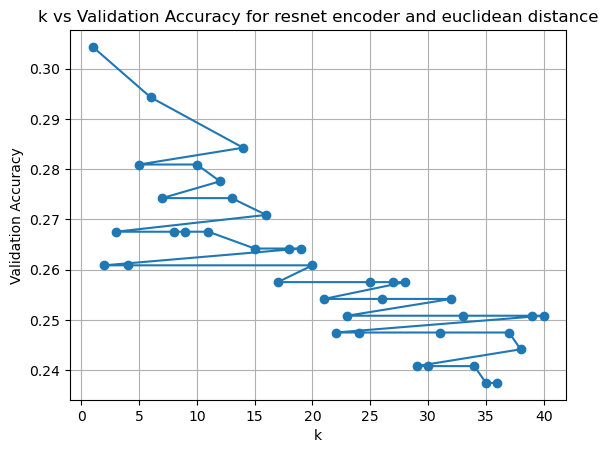

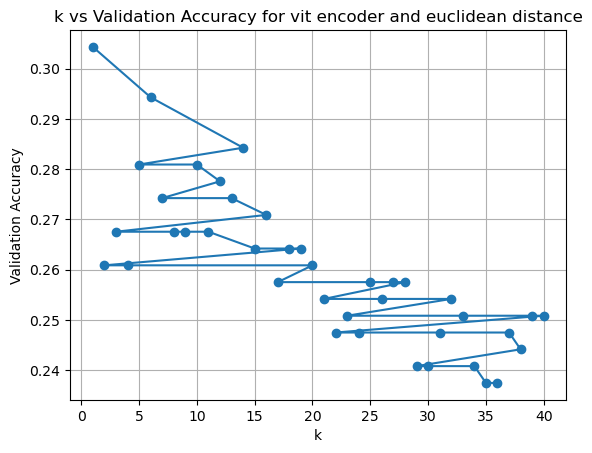

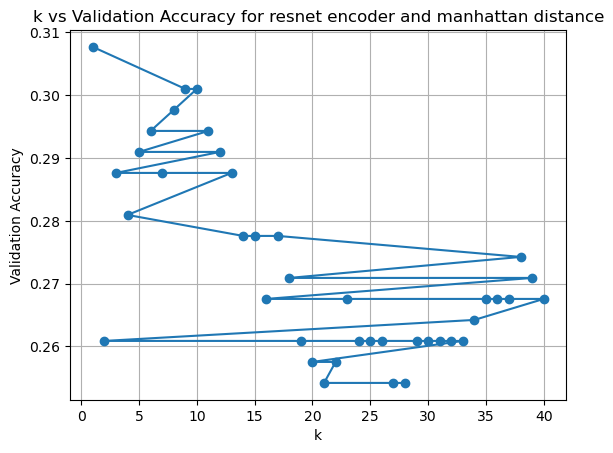

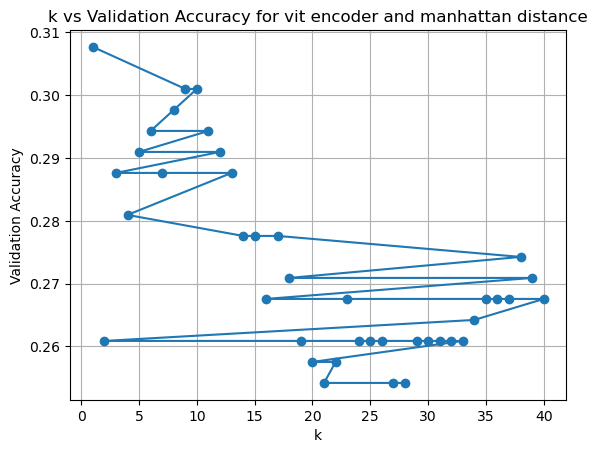

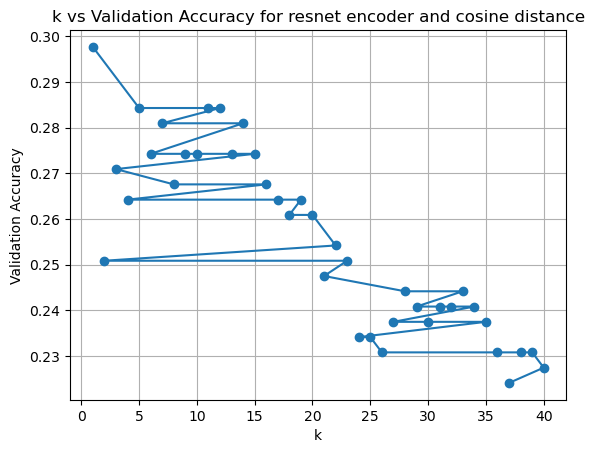

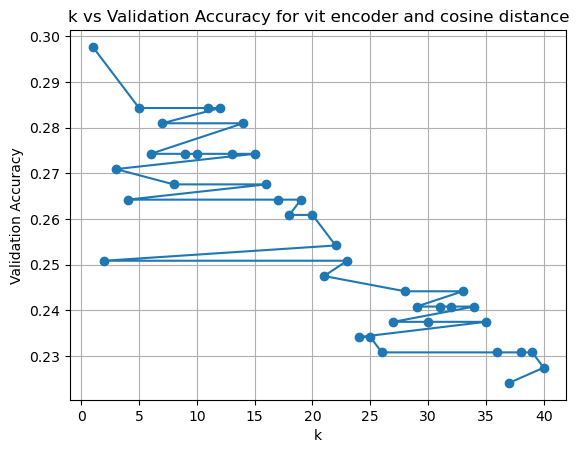

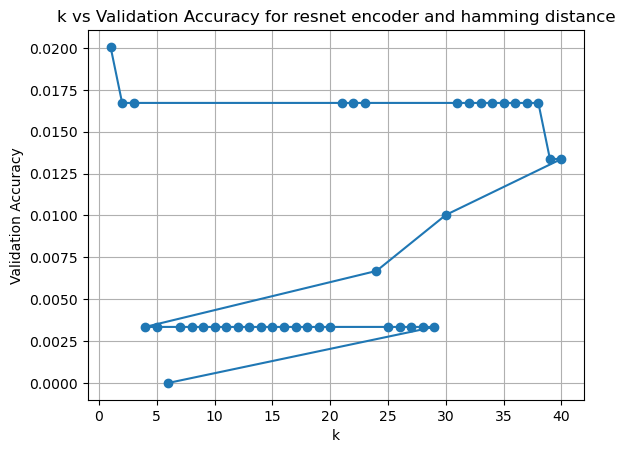

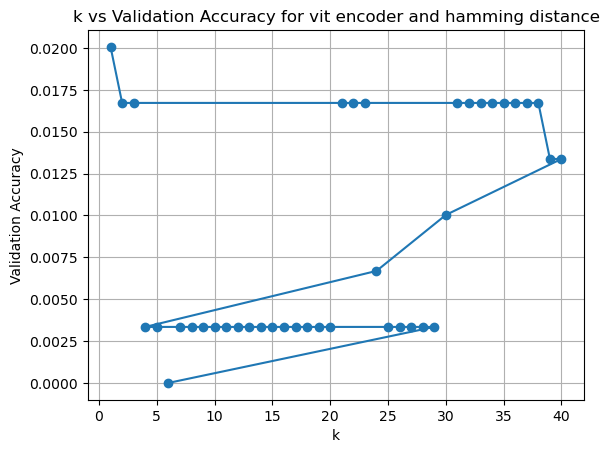

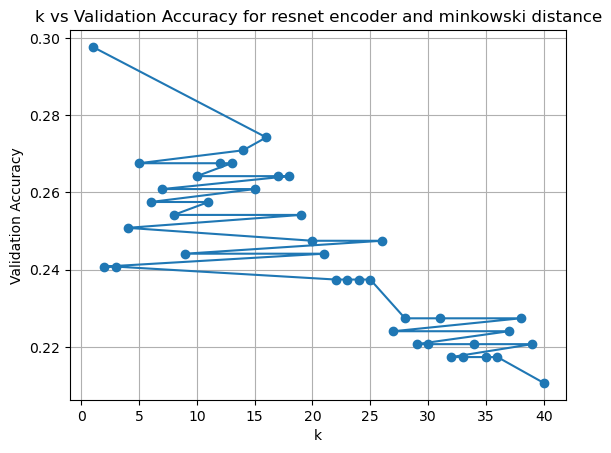

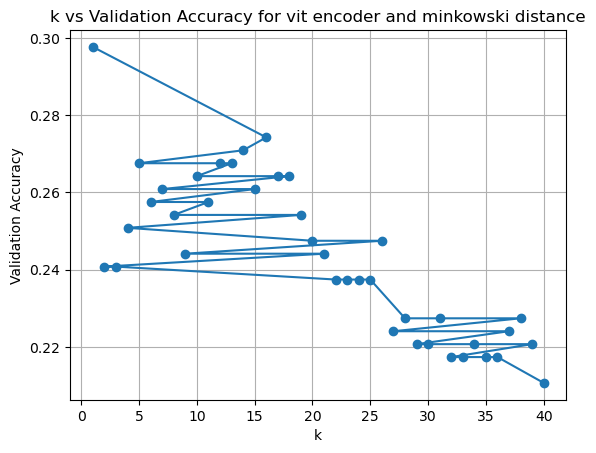

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


# KNN Class Definition
class KNN:
    def __init__(self, k=3, encoder_type="resnet", distance_metric="euclidean"):
        self.k = k
        self.encoder_type = encoder_type
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None
        self.label_to_int = {}
        self.int_to_label = {}

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def _manhattan_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2))
    
    def _cosine_distance(self, x1, x2):
        dot_product = np.dot(x1, x2)
        norm_x1 = np.linalg.norm(x1)
        norm_x2 = np.linalg.norm(x2)
        return 1 - (dot_product / (norm_x1 * norm_x2))
    
    def _hamming_distance(self, x1, x2):
        return np.sum(x1 != x2)
    
    def _minkowski_distance(self, x1, x2, p=3):
        return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)
    
    def fit(self, X, y):
        unique_labels = np.unique(y)
        self.label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        self.int_to_label = {idx: label for label, idx in self.label_to_int.items()}
        y_int = np.array([self.label_to_int[label] for label in y])
        self.X_train = X
        self.y_train = y_int
    
    def predict(self, X):
        y_pred_int = [self._predict(x) for x in X]
        y_pred = [self.int_to_label[y_int] for y_int in y_pred_int]
        return np.array(y_pred)
    
    def _predict(self, x):
        if self.distance_metric == "euclidean":
            distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "manhattan":
            distances = [self._manhattan_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "cosine":
            distances = [self._cosine_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "hamming":
            distances = [self._hamming_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "minkowski":
            distances = [self._minkowski_distance(x, x_train) for x_train in self.X_train]
        else:
            raise ValueError("Invalid distance metric.")
        
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common
    
    

    def train_val_evaluate(self, X_train, y_train, X_val, y_val):
        self.fit(X_train, y_train)
        return self.evaluate(X_val, y_val)


    def evaluate(self, X, y):
        y_pred = self.predict(X)
        f1 = f1_score(y, y_pred, average='macro', zero_division=1)
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average='macro', zero_division=1)
        recall = recall_score(y, y_pred, average='macro', zero_division=1)
        
        return {"f1_score": f1, "accuracy": accuracy, "precision": precision, "recall": recall}

# Load the data and preprocess as done previously
data = np.load('data.npy', allow_pickle=True)
X_resnet = data[:1500, 1]
X_vit = data[:1500, 2]
y = data[:1500, 3]

X_resnet_2D = np.vstack(X_resnet).reshape(-1, 1024)
X_vit_2D = np.vstack(X_vit).reshape(-1, 512)
X_combined = np.hstack([X_resnet_2D, X_vit_2D])

# Count the occurrences of each class in y
class_counts = Counter(y)

# Find classes with only one sample
single_sample_classes = [cls for cls, count in class_counts.items() if count < 2]

# Remove samples of those classes from X and y
mask = np.isin(y, single_sample_classes, invert=True)
X_combined_filtered = X_combined[mask]
y_filtered = y[mask]

# Using stratified sampling to ensure all classes are represented in both training and test sets
X_train_combined, X_val_combined, y_train, y_val = train_test_split(X_combined_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

# # Hyperparameter tuning
# k_values = list(range(1, 41))  # considering k values from 1 to 41
# distance_metrics = ["euclidean", "manhattan", "cosine", "hamming", "minkowski"]
# encoders = ["resnet", "vit"]

# results = []

# for k in k_values:
#     for distance in distance_metrics:
#         for encoder in encoders:
#             knn = KNN(k=k, encoder_type=encoder, distance_metric=distance)
#             evaluation = knn.train_val_evaluate(X_train_combined, y_train, X_val_combined, y_val)
#             accuracy = evaluation['accuracy']
#             results.append((accuracy, k, encoder, distance))

# # Sort the results based on accuracy
# sorted_results = sorted(results, key=lambda x: x[0], reverse=True)

# # Print top 20 combinations
# print("Top 20 (k, encoder, distance metric) combinations based on validation accuracy:")
# for idx, (accuracy, k, encoder, distance) in enumerate(sorted_results[:20]):
#     print(f"{idx + 1}. Accuracy: {accuracy:.4f}, k: {k}, Encoder: {encoder}, Distance: {distance}")

# # Plot k vs accuracy for a specific distance metric and encoder choice
# chosen_distance = "euclidean"
# chosen_encoder = "resnet"

# k_values_plot = []
# accuracies_plot = []

# for accuracy, k, encoder, distance in sorted_results:
#     if encoder == chosen_encoder and distance == chosen_distance:
#         k_values_plot.append(k)
#         accuracies_plot.append(accuracy)

# plt.plot(k_values_plot, accuracies_plot, marker='o')
# plt.xlabel('k')
# plt.ylabel('Validation Accuracy')
# plt.title(f'k vs Validation Accuracy for {chosen_encoder} encoder and {chosen_distance} distance')
# plt.grid(True)
# plt.show()

k_values = list(range(1, 41))  # considering k values up to 40, as you pointed out
distance_metrics = ["euclidean", "manhattan", "cosine", "hamming", "minkowski"]
encoders = ["resnet", "vit"]

results = []

for k in k_values:
    for distance in distance_metrics:
        for encoder in encoders:
            knn = KNN(k=k, encoder_type=encoder, distance_metric=distance)
            evaluation = knn.train_val_evaluate(X_train_combined, y_train, X_val_combined, y_val)
            accuracy = evaluation['accuracy']
            results.append((accuracy, k, encoder, distance))

# Sort the results based on accuracy
sorted_results = sorted(results, key=lambda x: x[0], reverse=True)

# Print top 20 combinations
print("Top 20 (k, encoder, distance metric) combinations based on validation accuracy:")
for idx, (accuracy, k, encoder, distance) in enumerate(sorted_results[:20]):
    print(f"{idx + 1}. Accuracy: {accuracy:.4f}, k: {k}, Encoder: {encoder}, Distance: {distance}")

# Plot k vs accuracy for each distance metric and encoder choice
for distance in distance_metrics:
    for encoder in encoders:
        k_values_plot = []
        accuracies_plot = []
        for accuracy, k, enc, dist in sorted_results:
            if enc == encoder and dist == distance:
                k_values_plot.append(k)
                accuracies_plot.append(accuracy)
        
        plt.figure()
        plt.plot(k_values_plot, accuracies_plot, marker='o')
        plt.xlabel('k')
        plt.ylabel('Validation Accuracy')
        plt.title(f'k vs Validation Accuracy for {encoder} encoder and {distance} distance')
        plt.grid(True)
        plt.show()


The below markdowns are with respect to Task 2.6.1:

The expected output [Verified with chatgpt and it's responses given below]:

1. Linear Increase in Time: The inference time generally increases as the number of samples in the training set increases. This is consistent with the O(N) time complexity of the KNN algorithm for inference.

2. Scikit-learn Efficiency: The Scikit-learn KNN implementation is generally more efficient than custom implementations, which is what your graph shows.

3. Optimized vs Best vs Initial: Your graph also suggests that your optimized and best models perform similarly, and both are better than the initial model. This could indicate that your optimization efforts had some impact, albeit not a large one, or that your best and optimized models are essentially the same in terms of computational efficiency.

ANALYSIS OF THE BELOW OUTPUT:

1. Inference Time for Different KNN Models:

-> The graph shows the inference time of various KNN models.
-> The Scikit-learn KNN model has the shortest inference time, indicating it's the most efficient among the four.
-> The initial, best, and optimized models (custom implementations) have more extended inference times, with the "best" and "optimized" versions having nearly the same performance. 

2. Inference Time vs. Training Data Size:

-> The graph shows how the inference time changes with varying training data sizes.
-> All models exhibit an increase in inference time as the training size increases, which is expected since KNN has to compute distances with more data points.
-> Again, the Scikit-learn KNN model performs the best, maintaining a relatively low inference time across all training sizes.
-> The initial, best, and optimized KNN models (custom implementations) have similar trends, but their inference times are notably higher.

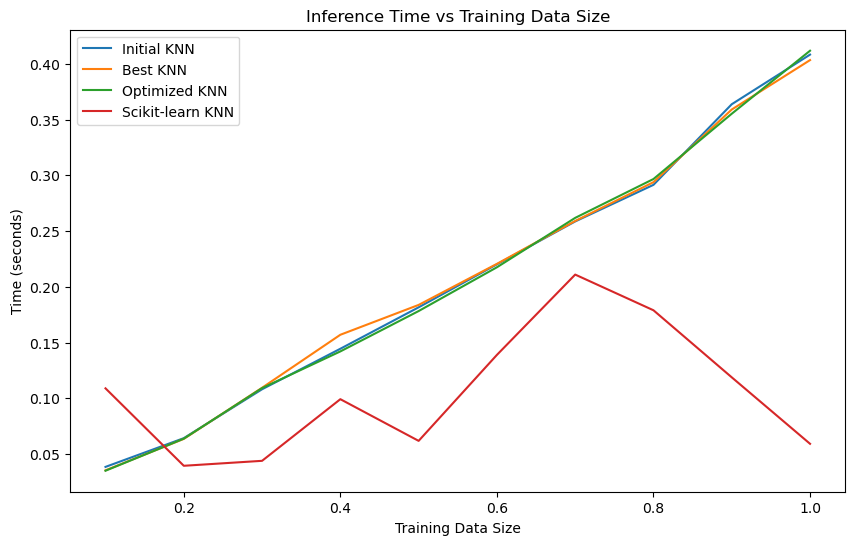

<Figure size 1000x600 with 0 Axes>

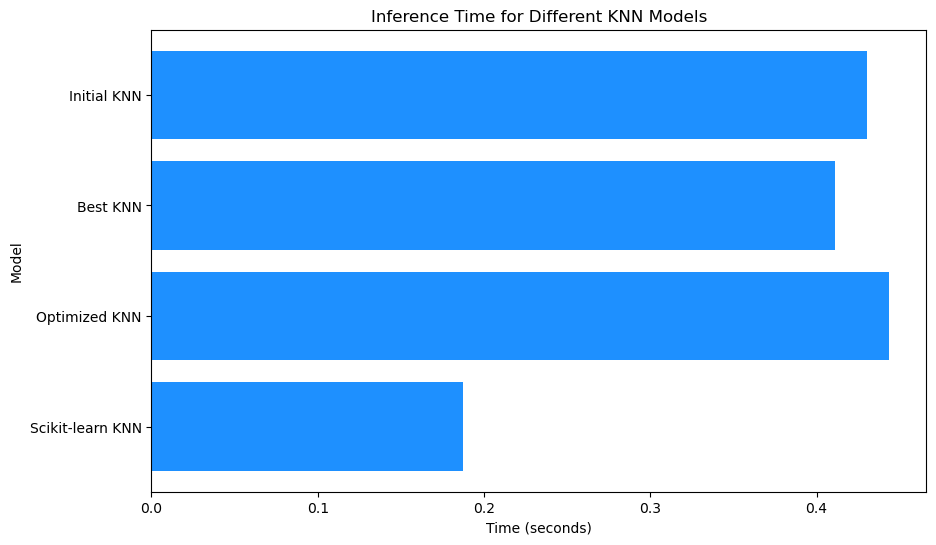

In [10]:
#Below is the implementation of 2.6.1 (Vectorized approach)

import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Load your data here
data = np.load('data.npy', allow_pickle=True)
X_resnet = data[:, 1]
X_vit = data[:, 2]
y = data[:, 3]
X_resnet_2D = np.vstack(X_resnet).reshape(-1, 1024)
X_vit_2D = np.vstack(X_vit).reshape(-1, 512)
X_combined = np.hstack([X_resnet_2D, X_vit_2D])

# Split the data into training and test sets
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

class KNN:
    def __init__(self, k=3, encoder_type="resnet", distance_metric="euclidean"):
        self.k = k
        self.encoder_type = encoder_type
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None
        self.label_to_int = {}
        self.int_to_label = {}

    def fit(self, X, y):
        unique_labels = np.unique(y)
        self.label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        self.int_to_label = {idx: label for label, idx in self.label_to_int.items()}
        y_int = np.array([self.label_to_int[label] for label in y])
        self.X_train = X
        self.y_train = y_int

    def predict(self, X):
        y_pred_int = [self._predict(x) for x in X]
        y_pred = [self.int_to_label[y_int] for y_int in y_pred_int]
        return np.array(y_pred)

    def _predict(self, x):
        if self.distance_metric == "euclidean":
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
        elif self.distance_metric == "manhattan":
            distances = np.sum(np.abs(self.X_train - x), axis=1)
        elif self.distance_metric == "cosine":
            dot_product = np.dot(self.X_train, x)
            norm_x = np.linalg.norm(x)
            norm_X_train = np.linalg.norm(self.X_train, axis=1)
            distances = 1 - (dot_product / (norm_x * norm_X_train))
        elif self.distance_metric == "hamming":
            distances = np.sum(self.X_train != x, axis=1)
        elif self.distance_metric == "minkowski":
            p = 3  # You can make 'p' a parameter if you like
            distances = np.sum(np.abs(self.X_train - x)**p, axis=1)**(1/p)
        else:
            raise ValueError("Invalid distance metric.")

        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        f1 = f1_score(y, y_pred, average='macro', zero_division=1)
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average='macro', zero_division=1)
        recall = recall_score(y, y_pred, average='macro', zero_division=1)

        return {"f1_score": f1, "accuracy": accuracy, "precision": precision, "recall": recall}

# Initialize models
initial_knn = KNN(k=3)
best_knn = KNN(k=10)  
optimized_knn = KNN(k=10)  
sklearn_knn = KNeighborsClassifier(n_neighbors=10)

# Time measurement function
def measure_time(model, X_test):
    start_time = time.time()
    predictions = model.predict(X_test)
    return time.time() - start_time

# Initialize variables for plotting
train_sizes = np.linspace(0.1, 1.0, 10)
times_initial = []
times_best = []
times_optimized = []
times_sklearn = []

# Measure inference time vs training data size
for size in train_sizes:
    if size == 1.0:
        X_train, y_train_subset = X_train_combined, y_train
    else:
        X_train, _, y_train_subset, _ = train_test_split(X_train_combined, y_train, train_size=size, random_state=42)

    initial_knn.fit(X_train, y_train_subset)
    best_knn.fit(X_train, y_train_subset)
    optimized_knn.fit(X_train, y_train_subset)
    sklearn_knn.fit(X_train, y_train_subset)

    times_initial.append(measure_time(initial_knn, X_test_combined))
    times_best.append(measure_time(best_knn, X_test_combined))
    times_optimized.append(measure_time(optimized_knn, X_test_combined))
    times_sklearn.append(measure_time(sklearn_knn, X_test_combined))

# Plotting inference time vs training data size
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, times_initial, label='Initial KNN')
plt.plot(train_sizes, times_best, label='Best KNN')
plt.plot(train_sizes, times_optimized, label='Optimized KNN')
plt.plot(train_sizes, times_sklearn, label='Scikit-learn KNN')
plt.xlabel('Training Data Size')
plt.ylabel('Time (seconds)')
plt.title('Inference Time vs Training Data Size')
plt.legend()
plt.show()

# Measure inference time for each model
initial_knn.fit(X_train_combined, y_train)
best_knn.fit(X_train_combined, y_train)
optimized_knn.fit(X_train_combined, y_train)
sklearn_knn.fit(X_train_combined, y_train)

time_initial = measure_time(initial_knn, X_test_combined)
time_best = measure_time(best_knn, X_test_combined)
time_optimized = measure_time(optimized_knn, X_test_combined)
time_sklearn = measure_time(sklearn_knn, X_test_combined)

# Plotting inference time for initial KNN model, best KNN model, most optimized KNN model, and the default sklearn KNN model.
labels = ['Initial KNN', 'Best KNN', 'Optimized KNN', 'Scikit-learn KNN']
times = [time_initial, time_best, time_optimized, time_sklearn]

plt.figure(figsize=(10, 6))


plt.figure(figsize=(10, 6))
plt.barh(labels, times, color='dodgerblue')
plt.xlabel('Time (seconds)')
plt.ylabel('Model')
plt.title('Inference Time for Different KNN Models')
plt.gca().invert_yaxis()  # This is to have the Initial KNN at the top and Scikit-learn KNN at the bottom
plt.show()


PART 2 - DECISION TREES 

In [11]:
# Import necessary libraries
import pandas as pd

# Load the data
try:
    data_dt = pd.read_csv('/home/aishani/Documents/GitHub/SMAI-Assignment-1/SMAI ASSIGNMENT 1/advertisement.csv')
    print("Data loaded successfully.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

# Display basic statistics
print("Basic Statistics:")
print(data_dt.describe())

# Display first few rows
print("First few rows:")
print(data_dt.head())


Data loaded successfully.
Basic Statistics:
               age        income     children  purchase_amount
count  1000.000000   1000.000000  1000.000000      1000.000000
mean     40.836000  49349.796167     1.508000       101.098170
std      13.786848   9894.479148     1.129253        20.348736
min      18.000000  21908.867759     0.000000        23.482179
25%      28.000000  42577.352034     0.000000        87.699577
50%      41.000000  48993.757137     1.000000       101.587560
75%      53.000000  56566.795992     3.000000       114.718926
max      64.000000  79459.294416     3.000000       168.978628
First few rows:
   age  gender        income    education  married  children           city  \
0   45    Male  61271.953359       Master    False         3    Lake Sheila   
1   24  Female  53229.101074  High School    False         1   Crystalburgh   
2   45  Female  30066.046684     Bachelor     True         3  Margaretburgh   
3   19    Male  48950.246384          PhD    False       

In [12]:
# Explore the 'labels' column
labels_col = data_dt['labels'].str.split(', ')

# Count the number of unique labels
unique_labels = set(x for sublist in labels_col for x in sublist)
print(f"Total number of unique labels: {len(unique_labels)}")

# Distribution of number of labels per instance
label_count_per_instance = labels_col.apply(len)
print("Distribution of number of labels per instance:")
print(label_count_per_instance.value_counts().sort_index())

# Count the number of unique label combinations
unique_label_combinations = set(tuple(sorted(x)) for x in labels_col)
print(f"Total number of unique label combinations: {len(unique_label_combinations)}")


Total number of unique labels: 397
Distribution of number of labels per instance:
labels
1    1000
Name: count, dtype: int64
Total number of unique label combinations: 397


In [13]:
import csv
 
# opening the CSV file
with open('/home/aishani/Documents/GitHub/SMAI-Assignment-1/SMAI ASSIGNMENT 1/advertisement.csv', mode ='r') as file: 
       
       # reading the CSV file
       data_dt = csv.DictReader(file)      
       
       # displaying the contents of the CSV file
       for lines in data_dt:
            print(lines)

{'age': '45', 'gender': 'Male', 'income': '61271.953358890096', 'education': 'Master', 'married': 'False', 'children': '3', 'city': 'Lake Sheila', 'occupation': 'Doctor', 'purchase_amount': '87.69711834242366', 'most bought item': 'monitor', 'labels': 'electronics clothing sports'}
{'age': '24', 'gender': 'Female', 'income': '53229.101073561775', 'education': 'High School', 'married': 'False', 'children': '1', 'city': 'Crystalburgh', 'occupation': 'Businessman', 'purchase_amount': '115.13558622549097', 'most bought item': 'lipstick', 'labels': 'furniture beauty'}
{'age': '45', 'gender': 'Female', 'income': '30066.04668359846', 'education': 'Bachelor', 'married': 'True', 'children': '3', 'city': 'Margaretburgh', 'occupation': 'Engineer', 'purchase_amount': '101.69455857438265', 'most bought item': 'biscuits', 'labels': 'clothing electronics food sports'}
{'age': '19', 'gender': 'Male', 'income': '48950.246384098704', 'education': 'PhD', 'married': 'False', 'children': '0', 'city': 'Will

   age  gender        income    education  married  children           city  \
0   45    Male  61271.953359       Master    False         3    Lake Sheila   
1   24  Female  53229.101074  High School    False         1   Crystalburgh   
2   45  Female  30066.046684     Bachelor     True         3  Margaretburgh   
3   19    Male  48950.246384          PhD    False         0  Williamshaven   
4   29  Female  44792.627094       Master    False         0       New Paul   

    occupation  purchase_amount most bought item  \
0       Doctor        87.697118          monitor   
1  Businessman       115.135586         lipstick   
2     Engineer       101.694559         biscuits   
3       Lawyer        97.964887            maggi   
4  Businessman        86.847281           carpet   

                             labels  
0       electronics clothing sports  
1                  furniture beauty  
2  clothing electronics food sports  
3                              food  
4                     

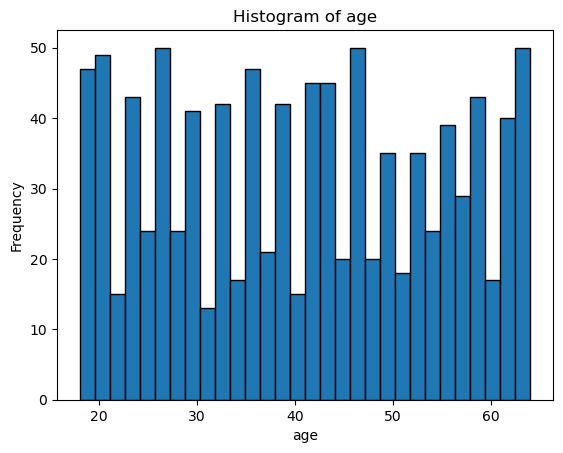

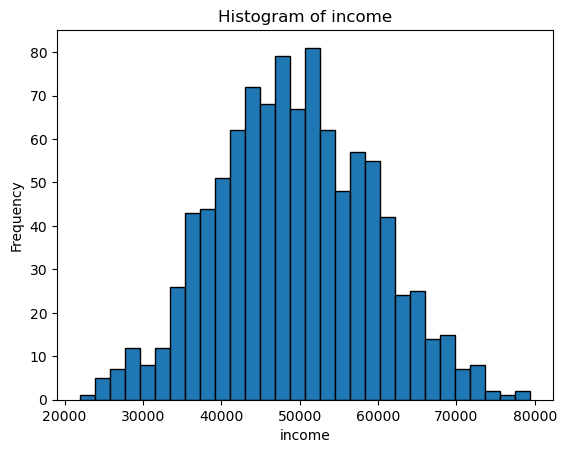

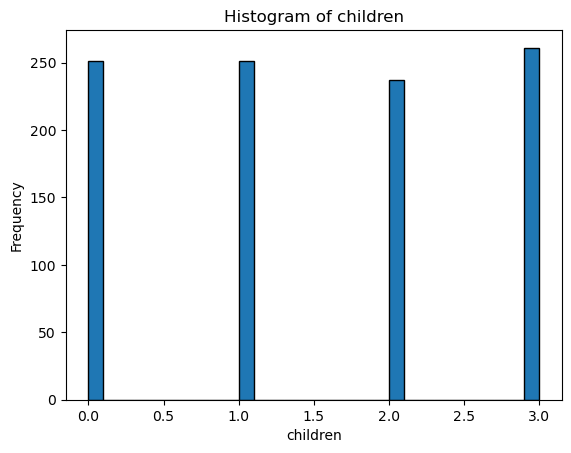

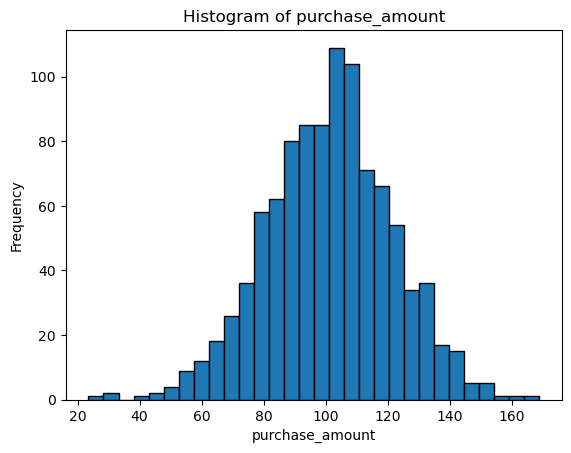

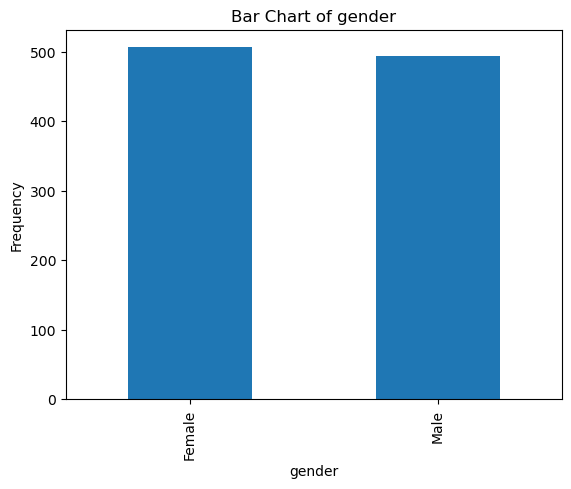

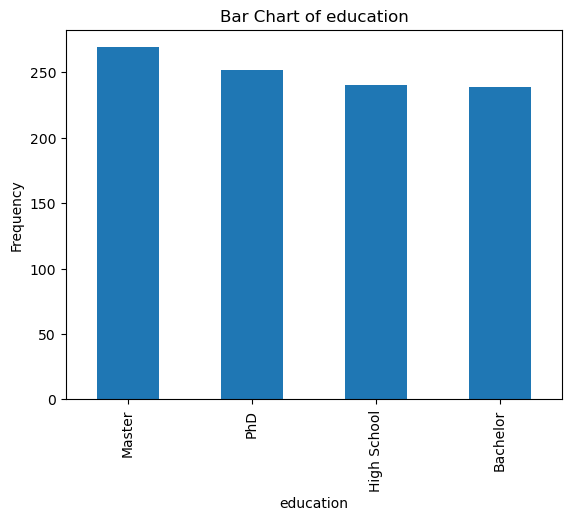

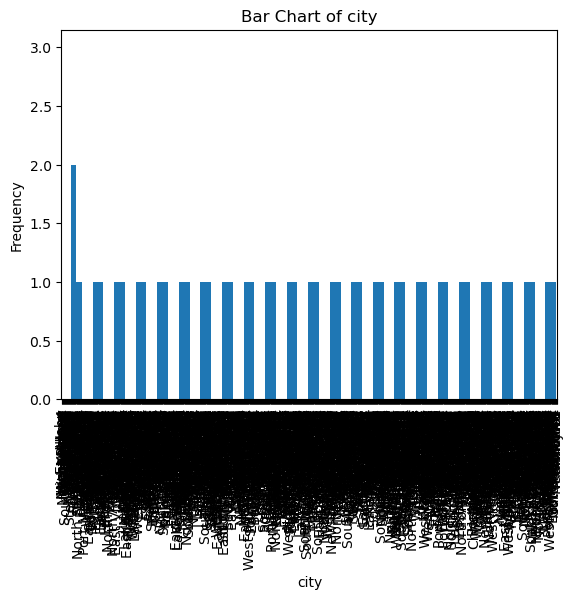

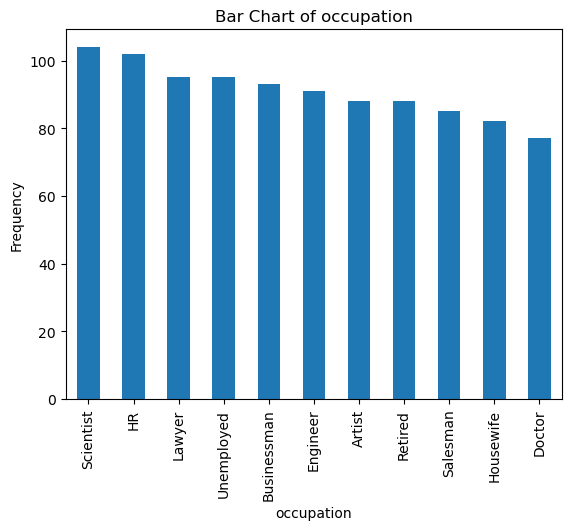

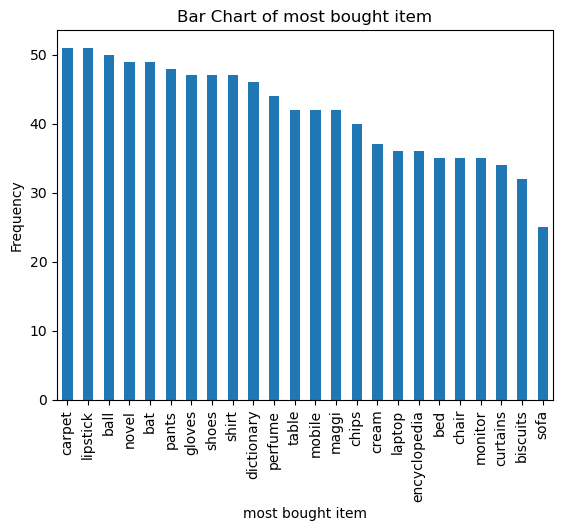

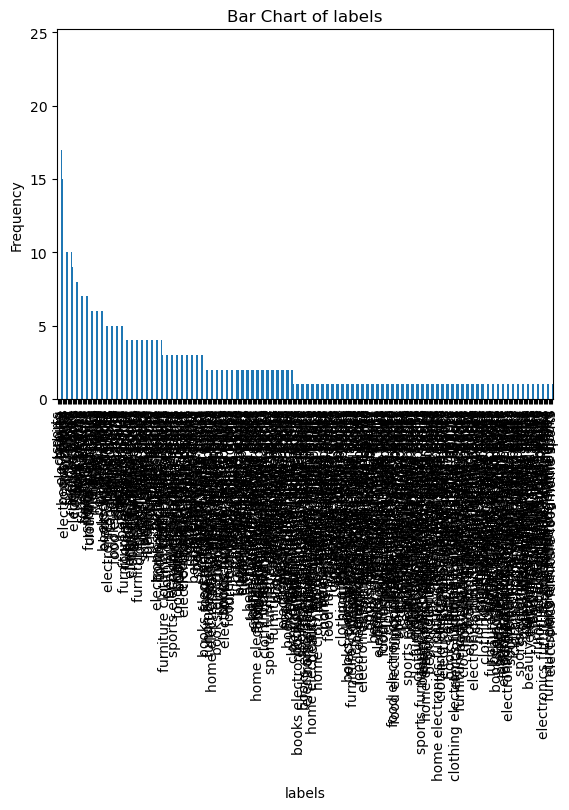

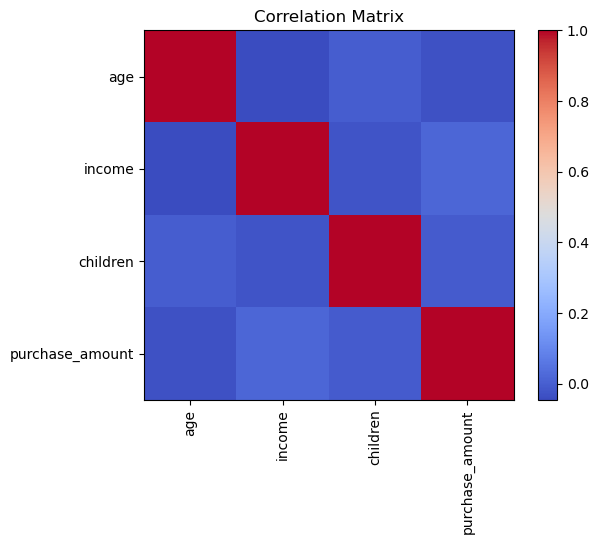

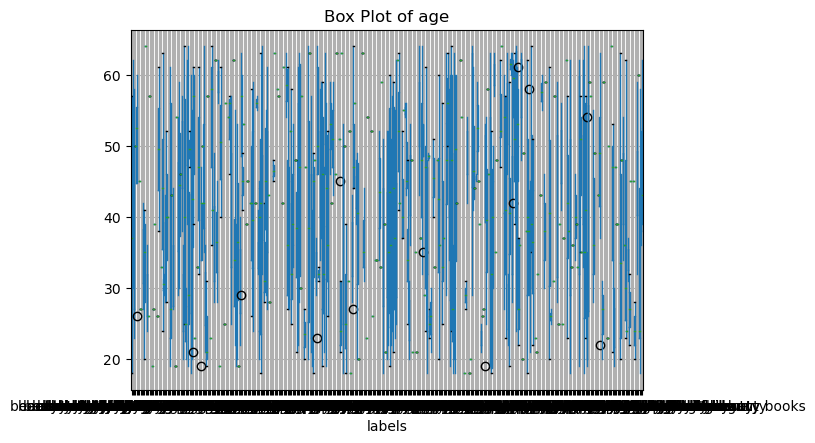

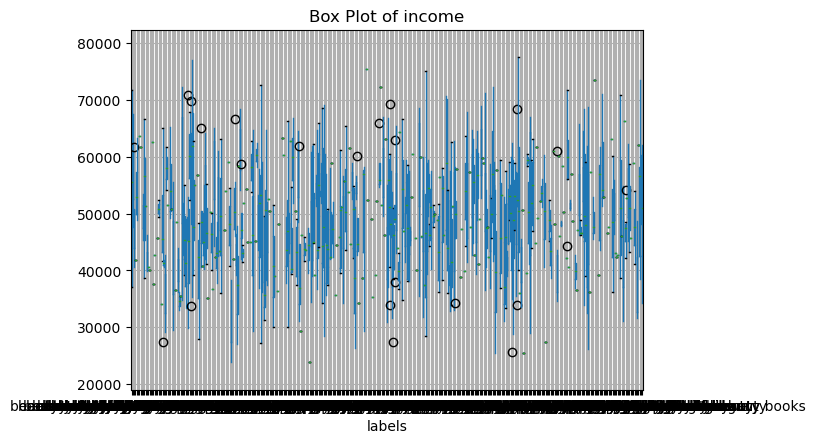

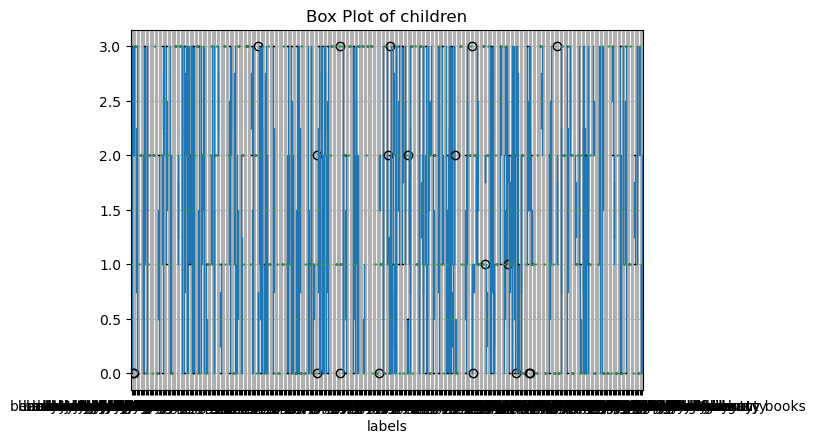

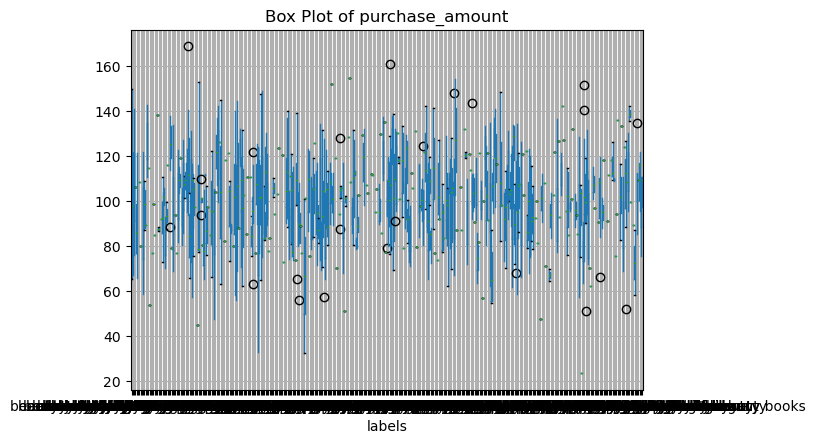

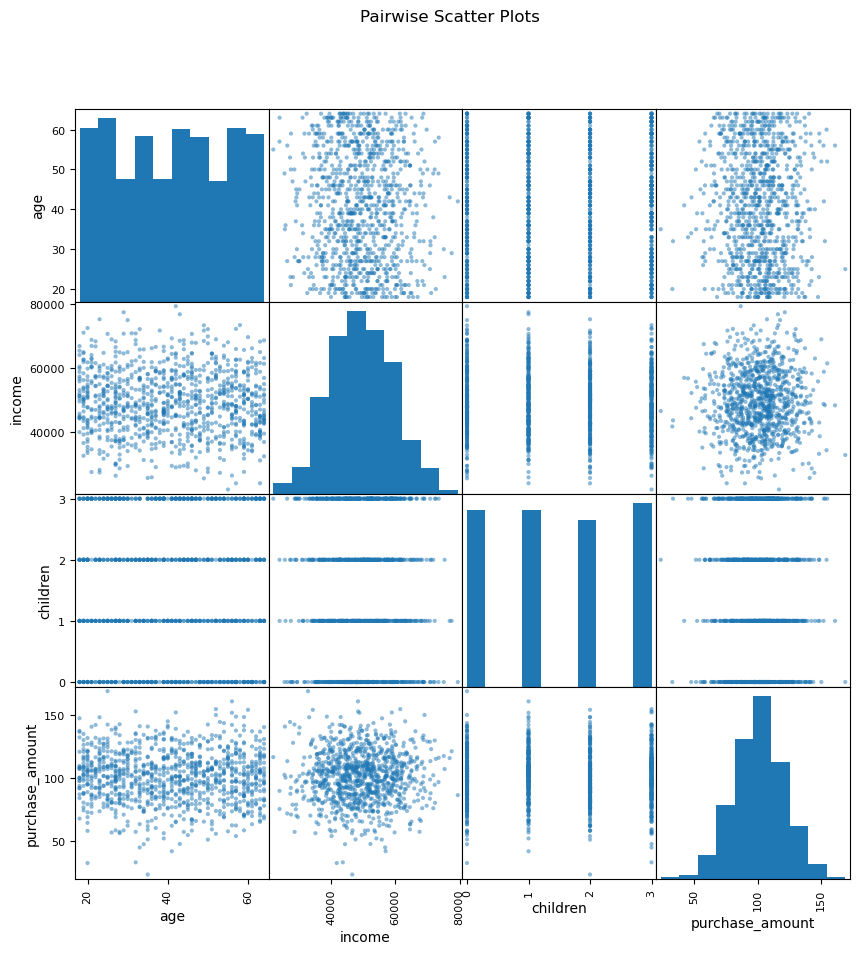

Data visualization and exploration complete


In [14]:
#Load dataset using Pandas Library

#Source- Chatgpt and Stack Overflow: Loading the dataset again using Pandas as further steps mentioned in Assignment document become simpler and easier to analyse.
#Prompt given to Chatgpt: Data Visualization using Pandas, and state it's advantages. Give basic outline of data visualization, preprocessing , featurization, train-val-test splitting
# Both DictReader and Pandas are used for analysing a csv data but DictReader requires more manual work for tasks like filtering, grouping, joining, and other common data processing operations. 
# Whereas using pandas would be much more efficient and straightforward. The majority of data science and machine learning workflows in Python leverage pandas due to its versatility and efficiency.

#Below is the code for loading dataset using Pandas

# data visualization and exploration
import numpy as np
import pandas as pd

# Load the dataset from CSV file
data_dt = pd.read_csv('/home/aishani/Documents/GitHub/SMAI-Assignment-1/SMAI ASSIGNMENT 1/advertisement.csv')
print(data_dt.head())
print(data_dt['labels'].value_counts())
print(data_dt.describe())

#View shape
print("Data Shape:", data_dt.shape)

import matplotlib.pyplot as plt

# 1. Histograms
numerical_features = data_dt.select_dtypes(include=[np.number]).columns.tolist()
for feature in numerical_features:
    plt.hist(data_dt[feature], bins=30, edgecolor='black')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# 2. Bar Charts
categorical_features = data_dt.select_dtypes(include=['object']).columns.tolist()
for feature in categorical_features:
    data_dt[feature].value_counts().plot(kind='bar')
    plt.title(f'Bar Chart of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# 3. Correlation Matrix
correlation_matrix = data_dt[numerical_features].corr()
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

# 4. Box Plots
for feature in numerical_features:
    data_dt.boxplot(column=feature, by='labels')  # Replace 'labels' with your actual label column name if different
    plt.title(f'Box Plot of {feature}')
    plt.suptitle('')  # Suppress default title
    plt.show()

# 5. Scatter Plots
# Using scatter_matrix from pandas for pairwise scatter plots
from pandas.plotting import scatter_matrix
scatter_matrix(data_dt[numerical_features], figsize=(10, 10), diagonal='hist', cmap='coolwarm')
plt.suptitle('Pairwise Scatter Plots')
plt.show()
print("Data visualization and exploration complete")




In [15]:
data_dt.info() #View summary/information of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1000 non-null   int64  
 1   gender            1000 non-null   object 
 2   income            1000 non-null   float64
 3   education         1000 non-null   object 
 4   married           1000 non-null   bool   
 5   children          1000 non-null   int64  
 6   city              1000 non-null   object 
 7   occupation        1000 non-null   object 
 8   purchase_amount   1000 non-null   float64
 9   most bought item  1000 non-null   object 
 10  labels            1000 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 79.2+ KB


In [10]:
#Below is the implementation of 3.3.1 Task 1


####################################################################################################################################################################

'''  

SOURCE - CHATGPT 

Why I used Chatgpt:
I wrote the below code for data preprocessing and data featurization:

"
# Load data
data_dt = pd.read_csv('/home/aishani/Documents/GitHub/SMAI-Assignment-1/SMAI ASSIGNMENT 1/advertisement.csv')

# Data preprocessing
# 1. Handling Missing Values
for column in data_dt.select_dtypes(include=[np.number]).columns:
    data_dt[column].fillna(data_dt[column].median(), inplace=True)
# 2. Removing Duplicates
data_dt.drop_duplicates(inplace=True)
# 3. Outlier Removal (using Z-score)
z_scores = np.abs(stats.zscore(data_dt.select_dtypes(include=[np.number])))
data_dt = data_dt[(z_scores < 3).all(axis=1)]

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in data_dt.select_dtypes(include=['object']).columns:
    if column != 'labels':
        data_dt[column] = label_encoder.fit_transform(data_dt[column])

print("Data Preprocessing complete.")

# Limit to first 10 unique labels for demonstration
unique_labels = list(set([item for sublist in data_dt['labels'].str.split(', ') for item in sublist]))
limited_labels = unique_labels[:10]

# Count how many rows contain the limited labels
count_rows_with_limited_labels = data_dt['labels'].apply(lambda x: len(set(x.split(', ')) & set(limited_labels)) > 0).sum()
print("Rows with limited labels:", count_rows_with_limited_labels)

# Filter rows so that only limited labels are included
data_dt['labels'] = data_dt['labels'].str.split(', ').apply(lambda x: list(set(x) & set(limited_labels)))

# Remove rows with no labels after filtering
data_dt = data_dt[data_dt['labels'].apply(len) > 0]

# Data Featurization (interaction terms)
data_dt['age_income'] = data_dt['age'] * data_dt['income']
data_dt['age_children'] = data_dt['age'] * data_dt['children']
data_dt['income_children'] = data_dt['income'] * data_dt['children']
data_dt['income_purchase_amount'] = data_dt['income'] * data_dt['purchase_amount']

print("Data Featurization complete. Added interaction terms.")

# Separate features and target variable
X = data_dt.drop(['labels'], axis=1)
y = data_dt['labels']

# Convert labels to indicator matrix
mlb = MultiLabelBinarizer()

# Separate features and target variable
X = data_dt.drop(['labels'], axis=1)
y = data_dt['labels']

# Convert labels to indicator matrix
mlb = MultiLabelBinarizer()
y_indicator = mlb.fit_transform(y)
# y_test_binarized = mlb.tranform (y_test)
"

But my VS Code kept crashing. Reason for it was that it was using a lot of CPU time and heavy computation for forming powersets.

Prompt given to ChatGPT:

I wrote the below code:
"
def custom_f1_score(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1), axis=0)
    FP = np.sum((y_true == 0) & (y_pred == 1), axis=0)
    FN = np.sum((y_true == 1) & (y_pred == 0), axis=0)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    f1_micro = 2 * np.sum(precision * recall) / (np.sum(precision) + np.sum(recall))
    
    return f1_micro



from itertools import chain, combinations
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from scipy import stats
import pandas as pd

# Custom Classifier Class
# class PowersetDecisionTreeClassifier:
#     def __init__(self, max_depth=None, max_features=None, criterion='gini', max_nodes=100, min_impurity_decrease=0.0):
#         self.max_depth = max_depth
#         self.max_features = max_features
#         self.criterion = criterion
#         self.max_nodes = max_nodes
#         self.min_impurity_decrease = min_impurity_decrease
#         self.model = DecisionTreeClassifier(
#             max_depth=self.max_depth,
#             max_features=self.max_features,
#             criterion=self.criterion,
#             max_leaf_nodes=self.max_nodes,
#             min_impurity_decrease=self.min_impurity_decrease
#         )
#         self.pset = None

#     def fit(self, X_train, y_train):
#         y_powerset_train, self.pset = create_powerset_labels(y_train)
        
#         # Debug: Check the dimensions
#         print("Length of X_train:", len(X_train))
#         print("Length of y_powerset_train:", len(y_powerset_train))
        
#         self.model.fit(X_train, y_powerset_train)

    # def predict(self, X_val):
    #     y_powerset_val_pred = self.model.predict(X_val)
    #     y_val_pred = powerset_to_indicator(y_powerset_val_pred, self.pset, len(self.pset[0]))
    #     return y_val_pred

    # def predict(self, X_val):
    #     y_powerset_val_pred = self.model.predict(X_val)
    #     y_val_pred = powerset_to_indicator(y_powerset_val_pred, self.pset, self.n_classes)
    #     return y_val_pred

class PowersetDecisionTreeClassifier:
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.model = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
        self.pset = None

    def fit(self, X_train, y_train):
        y_powerset_train, self.pset = create_powerset_labels(y_train)
        self.model.fit(X_train, y_powerset_train)

    def predict(self, X_val):
        y_powerset_val_pred = self.model.predict(X_val)
        y_val_pred = powerset_to_indicator(y_powerset_val_pred, self.pset, len(self.pset[0]))
        return y_val_pred

# Function to generate limited subsets of a set
def limited_powerset(s, max_size=4):
    return list(chain.from_iterable(combinations(s, r) for r in range(min(len(s) + 1, max_size + 1))))

# Function to create powerset labels based on unique label combinations
def create_powerset_labels(y_multi_indicator):
    unique_combinations = set()
    for labels in y_multi_indicator:
        unique_combinations.add(tuple(np.where(labels == 1)[0]))
        
    pset = list(unique_combinations)
    y_powerset = []
    
    for labels in y_multi_indicator:
        subset_index = pset.index(tuple(np.where(labels == 1)[0]))
        y_powerset.append(subset_index)
        
    return np.array(y_powerset), pset

# Function to convert powerset predictions to indicator matrix
def powerset_to_indicator(powerset_predictions, pset, n_classes):
    indicator_matrix = np.zeros((len(powerset_predictions), n_classes))
    for i, pred in enumerate(powerset_predictions):
        for label in pset[pred]:
            indicator_matrix[i, label] = 1
    return indicator_matrix

# Load data
data_dt = pd.read_csv('/home/aishani/Documents/GitHub/SMAI-Assignment-1/SMAI ASSIGNMENT 1/advertisement.csv')

# Data preprocessing
for column in data_dt.select_dtypes(include=[np.number]).columns:
    data_dt[column].fillna(data_dt[column].median(), inplace=True)
data_dt.drop_duplicates(inplace=True)
z_scores = np.abs(stats.zscore(data_dt.select_dtypes(include=[np.number])))
data_dt = data_dt[(z_scores < 3).all(axis=1)]

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in data_dt.select_dtypes(include=['object']).columns:
    if column != 'labels':
        data_dt[column] = label_encoder.fit_transform(data_dt[column])

# Data Featurization
data_dt['age_income'] = data_dt['age'] * data_dt['income']
data_dt['age_children'] = data_dt['age'] * data_dt['children']
data_dt['income_children'] = data_dt['income'] * data_dt['children']
data_dt['income_purchase_amount'] = data_dt['income'] * data_dt['purchase_amount']

# Separate features and labels, and convert labels to indicator matrix
X = data_dt.drop(['labels'], axis=1)
y = data_dt['labels']
mlb = MultiLabelBinarizer()
y_indicator = mlb.fit_transform(y)

# Capture the number of classes
# n_classes = y_indicator.shape[1]

# Train-Validation-Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_indicator, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Initialize and train your custom classifier
custom_classifier = PowersetDecisionTreeClassifier(max_depth=5, max_features='sqrt', criterion='gini', max_nodes=100, min_impurity_decrease=0.01)
# custom_classifier.n_classes = n_classes  # Explicitly set the number of classes
custom_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = custom_classifier.predict(X_val)

# Calculate metrics
f1_micro = f1_score(y_val, y_val_pred, average='micro')
f1_macro = f1_score(y_val, y_val_pred, average='macro')
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='micro')
recall = recall_score(y_val, y_val_pred, average='micro')
conf_matrix = confusion_matrix(y_val.argmax(axis=1), y_val_pred.argmax(axis=1))

# Print metrics
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix: \n{conf_matrix}")


from sklearn.model_selection import KFold

# Initialize variables to store best metrics and hyperparameters
best_f1_powerset = 0
best_hyperparameters_powerset = None
top_hyperparameters_powerset = []

kf = KFold(n_splits=5)

# Loop through all hyperparameter combinations
for max_depth, max_features, criterion in hyperparameter_combinations:
    f1_scores = []
    for train_index, val_index in kf.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]
        
        custom_classifier = PowersetDecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
        custom_classifier.fit(X_train, y_train)
        
        y_val_pred = custom_classifier.predict(X_val)
        f1_micro = custom_f1_score(y_val, y_val_pred)
        f1_scores.append(f1_micro)
    
    avg_f1 = np.mean(f1_scores)
    print(f"Average F1 Score (Micro) for hyperparameters {max_depth, max_features, criterion}: {avg_f1}")
    
    top_hyperparameters_powerset.append((avg_f1, (max_depth, max_features, criterion)))

# Sort and take the top 3 hyperparameter sets
top_hyperparameters_powerset.sort(reverse=True)
top_hyperparameters_powerset = top_hyperparameters_powerset[:3]

print(f"Top 3 hyperparameters for Powerset Setting: {top_hyperparameters_powerset}")


" 

And my VSCode keeps crashing. Why? Give me the code which performing the similar task which would work
'''

####################################################################################################################################################################

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np
from itertools import product

# Define custom metrics
def custom_f1_score(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1), axis=0)
    FP = np.sum((y_true == 0) & (y_pred == 1), axis=0)
    FN = np.sum((y_true == 1) & (y_pred == 0), axis=0)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    f1_micro = 2 * np.sum(precision * recall) / (np.sum(precision) + np.sum(recall))
    
    return f1_micro

# Custom Classifier Class for Powerset approach
class PowersetDecisionTreeClassifier:
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.model = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
        self.pset = None

    def fit(self, X_train, y_train):
        y_powerset_train, self.pset = self.create_powerset_labels(y_train)
        self.model.fit(X_train, y_powerset_train)

    def predict(self, X_val):
        y_powerset_val_pred = self.model.predict(X_val)
        y_val_pred = self.powerset_to_indicator(y_powerset_val_pred)
        return y_val_pred

    @staticmethod
    def create_powerset_labels(y_multi_indicator):
        unique_combinations = set(map(tuple, y_multi_indicator.tolist()))
        pset = list(unique_combinations)
        y_powerset = [pset.index(tuple(row)) for row in y_multi_indicator.tolist()]
        return np.array(y_powerset), pset

    def powerset_to_indicator(self, powerset_predictions):
        n = len(self.pset[0])
        indicator_matrix = np.zeros((len(powerset_predictions), n))
        for i, pred in enumerate(powerset_predictions):
            indicator_matrix[i] = self.pset[pred]
        return indicator_matrix




import pandas as pd
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

data_dt = pd.read_csv("/home/aishani/Documents/GitHub/SMAI-Assignment-1/SMAI ASSIGNMENT 1/advertisement.csv")

#Below part done using chatgpt

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encoding all categorical variables
for col in data_dt.select_dtypes(include=['object']).columns:
    if col != 'labels':  # We will handle 'labels' separately
        data_dt[col] = label_encoder.fit_transform(data_dt[col])

# Binning 
binning = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
for col in data_dt.select_dtypes(include=['float64', 'int64']).columns:
    if col != 'labels':  
        data_dt[col] = binning.fit_transform(data_dt[[col]])

# Adding interaction terms (Product of each pair of feature)
data_dt_interaction = pd.DataFrame()
columns = data_dt.columns.tolist()
for col1 in columns:
    for col2 in columns:
        if col1 != col2 and col1 != 'labels' and col2 != 'labels':
            data_dt_interaction[f'{col1}_x_{col2}'] = data_dt[col1] * data_dt[col2]
data_dt = pd.concat([data_dt, data_dt_interaction], axis=1)

# Convert 'labels' to multi-label indicator format
mlb = MultiLabelBinarizer()
data_dt['labels'] = data_dt['labels'].apply(lambda x: x.split(' '))
labels_encoded = mlb.fit_transform(data_dt['labels'])
labels_data_dt = pd.DataFrame(labels_encoded, columns=mlb.classes_)

# Combine original data_dt with one-hot encoded labels
data_dt = data_dt.drop(columns=['labels'])
data_dt = pd.concat([data_dt, labels_data_dt], axis=1)

data_dt.head()

'''

X = data_dt.drop("labels", axis=1).values
y = data_dt["labels"].values

X = None  # Your feature matrix
y = None  # Your label matrix
'''
# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter combinations
max_depths = [None, 5, 10]
max_features_list = ['sqrt', 'log2', None]
criterions = ['gini', 'entropy']

# Store metrics
best_f1 = 0
best_hyperparameters = None

# Iterate through hyperparameter combinations
for max_depth, max_features, criterion in product(max_depths, max_features_list, criterions):
    
    # Initialize and train classifier
    classifier = PowersetDecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
    classifier.fit(X_train, y_train)
    
    # Predict on validation set
    y_val_pred = classifier.predict(X_val)
    
    # Compute metrics
    f1_micro = custom_f1_score(y_val, y_val_pred)
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='micro')
    recall = recall_score(y_val, y_val_pred, average='micro')
    conf_matrix = confusion_matrix(y_val.argmax(axis=1), y_val_pred.argmax(axis=1))
    
    # Update best hyperparameters based on F1 score
    if f1_micro > best_f1:
        best_f1 = f1_micro
        best_hyperparameters = (max_depth, max_features, criterion)
    
    # Print metrics for current hyperparameters
    print(f"For hyperparameters max_depth: {max_depth}, max_features: {max_features}, criterion: {criterion}")
    print(f"F1 Score (Micro): {f1_micro}")
    print(f"F1 Score (Macro): {f1_macro}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Confusion Matrix: \n{conf_matrix}\n")

print(f"Best hyperparameters based on F1 score are: {best_hyperparameters}")


For hyperparameters max_depth: None, max_features: sqrt, criterion: gini
F1 Score (Micro): 0.47248893735583
F1 Score (Macro): 0.47171825809229434
Accuracy: 0.16
Precision: 0.45535714285714285
Recall: 0.49038461538461536
Confusion Matrix: 
[[56 14 12]
 [27 14  8]
 [13  5  1]]

For hyperparameters max_depth: None, max_features: sqrt, criterion: entropy
F1 Score (Micro): 0.5049543120946272
F1 Score (Macro): 0.5034504590060145
Accuracy: 0.14
Precision: 0.4826086956521739
Recall: 0.5336538461538461
Confusion Matrix: 
[[44 26 12]
 [22 20  7]
 [ 8  9  2]]

For hyperparameters max_depth: None, max_features: log2, criterion: gini
F1 Score (Micro): 0.43407545805644543
F1 Score (Macro): 0.43198445998446
Accuracy: 0.08
Precision: 0.42592592592592593
Recall: 0.4423076923076923
Confusion Matrix: 
[[44 27 11]
 [30 10  9]
 [ 7  9  3]]

For hyperparameters max_depth: None, max_features: log2, criterion: entropy
F1 Score (Micro): 0.4335447844858321
F1 Score (Macro): 0.4190008689703626
Accuracy: 0.1
Prec

In [11]:
#Below is the 3.3.1 Task 2

''' 
Source Chatgpt as similar error was being encountered as in Task 3.3.1 Task 2 and my VSCode kept crashing. I wrote the similar prompt and gave my code
to Chatgpt and it gave me the code which works

'''


import pandas as pd
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

data_dt = pd.read_csv("/home/aishani/Documents/GitHub/SMAI-Assignment-1/SMAI ASSIGNMENT 1/advertisement.csv")

#Below part done using chatgpt

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encoding all categorical variables
for col in data_dt.select_dtypes(include=['object']).columns:
    if col != 'labels':  # We will handle 'labels' separately
        data_dt[col] = label_encoder.fit_transform(data_dt[col])

# Binning 
binning = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
for col in data_dt.select_dtypes(include=['float64', 'int64']).columns:
    if col != 'labels':  
        data_dt[col] = binning.fit_transform(data_dt[[col]])

# Adding interaction terms (Product of each pair of feature)
data_dt_interaction = pd.DataFrame()
columns = data_dt.columns.tolist()
for col1 in columns:
    for col2 in columns:
        if col1 != col2 and col1 != 'labels' and col2 != 'labels':
            data_dt_interaction[f'{col1}_x_{col2}'] = data_dt[col1] * data_dt[col2]
data_dt = pd.concat([data_dt, data_dt_interaction], axis=1)

# Convert 'labels' to multi-label indicator format
mlb = MultiLabelBinarizer()
data_dt['labels'] = data_dt['labels'].apply(lambda x: x.split(' '))
labels_encoded = mlb.fit_transform(data_dt['labels'])
labels_data_dt = pd.DataFrame(labels_encoded, columns=mlb.classes_)

# Combine original data_dt with one-hot encoded labels
data_dt = data_dt.drop(columns=['labels'])
data_dt = pd.concat([data_dt, labels_data_dt], axis=1)

data_dt.head()

from sklearn.multioutput import MultiOutputClassifier
from itertools import product

# Custom Classifier Class for MultiOutput Decision Tree
class MultiOutputDecisionTreeClassifier:
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.model = MultiOutputClassifier(DecisionTreeClassifier(max_depth=self.max_depth, 
                                                                  max_features=self.max_features, 
                                                                  criterion=self.criterion))

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_val):
        return self.model.predict(X_val)


# Define hyperparameter space
max_depths = [None, 5, 10]
max_features_options = ['sqrt', 'log2', None]
criterions = ['gini', 'entropy']

# Generate all possible combinations of hyperparameters
hyperparameter_combinations = list(product(max_depths, max_features_options, criterions))

# Initialize variables to store best metrics and hyperparameters
best_f1_micro = 0
best_f1_macro = 0
best_hyperparameters = None

# Loop through all hyperparameter combinations
for max_depth, max_features, criterion in hyperparameter_combinations:
    print(f"Training with max_depth: {max_depth}, max_features: {max_features}, criterion: {criterion}")
    
    # Initialize and train classifier
    multi_output_classifier = MultiOutputDecisionTreeClassifier(max_depth=max_depth, 
                                                                max_features=max_features, 
                                                                criterion=criterion)
    multi_output_classifier.fit(X_train, y_train)

    # Make predictions on the validation set
    y_val_pred = multi_output_classifier.predict(X_val)

    # Calculate metrics
    f1_micro = f1_score(y_val, y_val_pred, average='micro')
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    
    print(f"F1 Score (Micro): {f1_micro}")
    print(f"F1 Score (Macro): {f1_macro}")
    
    # Update best metrics and hyperparameters
    if f1_micro > best_f1_micro:
        best_f1_micro = f1_micro
        best_f1_macro = f1_macro
        best_hyperparameters = (max_depth, max_features, criterion)

# Print best metrics and hyperparameters
print(f"Best F1 Score (Micro): {best_f1_micro}")
print(f"Best F1 Score (Macro): {best_f1_macro}")
print(f"Best Hyperparameters: {best_hyperparameters}")

# Train the final model using the best hyperparameters
final_model = MultiOutputDecisionTreeClassifier(*best_hyperparameters)
final_model.fit(X_train, y_train)

# Make predictions on the validation set using the final model
y_val_pred = final_model.predict(X_val)

# Calculate metrics for the final model
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='micro')
recall = recall_score(y_val, y_val_pred, average='micro')
conf_matrix = confusion_matrix(y_val.argmax(axis=1), y_val_pred.argmax(axis=1))

# Print metrics for the final model
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix: \n{conf_matrix}")


Training with max_depth: None, max_features: sqrt, criterion: gini
F1 Score (Micro): 0.4743276283618582
F1 Score (Macro): 0.47385030772285086
Training with max_depth: None, max_features: sqrt, criterion: entropy
F1 Score (Micro): 0.4697336561743341
F1 Score (Macro): 0.47028793295659854
Training with max_depth: None, max_features: log2, criterion: gini
F1 Score (Micro): 0.5245901639344263
F1 Score (Macro): 0.5220034445840898
Training with max_depth: None, max_features: log2, criterion: entropy
F1 Score (Micro): 0.47663551401869153
F1 Score (Macro): 0.47561078529439027
Training with max_depth: None, max_features: None, criterion: gini
F1 Score (Micro): 0.4564705882352941
F1 Score (Macro): 0.4569415964152806
Training with max_depth: None, max_features: None, criterion: entropy
F1 Score (Micro): 0.4316546762589928
F1 Score (Macro): 0.43076920014947034
Training with max_depth: 5, max_features: sqrt, criterion: gini
F1 Score (Micro): 0.3705882352941176
F1 Score (Macro): 0.33934515514833663
T

Hyperparameter Tuning

In [12]:
#Below is implementation of 3.4.1 for Powerset setting (all tasks)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np
from itertools import product


# Define custom metrics
def custom_f1_score(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1), axis=0)
    FP = np.sum((y_true == 0) & (y_pred == 1), axis=0)
    FN = np.sum((y_true == 1) & (y_pred == 0), axis=0)

    precision = TP / (TP + FP)
    if (TP.all() == 0 and FP.all()==0):
        precision = np.zeros_like(TP)
    recall = TP / (TP + FN)
    if (TP.all() == 0 and FN.all()==0):
        recall = np.zeros_like(TP)
    
    if( TP.all() == 0 and FN.all()==0  and FP.all()==0 ):
        return 0
    
    f1_micro = 2 * np.sum(precision * recall) / (np.sum(precision) + np.sum(recall))
    
    
    
    return f1_micro

# Custom Classifier Class for Powerset approach
class PowersetDecisionTreeClassifier:
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.model = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
        self.pset = None

    def fit(self, X_train, y_train):
        y_powerset_train, self.pset = self.create_powerset_labels(y_train)
        self.model.fit(X_train, y_powerset_train)

    def predict(self, X_val):
        y_powerset_val_pred = self.model.predict(X_val)
        y_val_pred = self.powerset_to_indicator(y_powerset_val_pred)
        return y_val_pred

    @staticmethod
    def create_powerset_labels(y_multi_indicator):
        unique_combinations = set(map(tuple, y_multi_indicator.tolist()))
        pset = list(unique_combinations)
        y_powerset = [pset.index(tuple(row)) for row in y_multi_indicator.tolist()]
        return np.array(y_powerset), pset

    def powerset_to_indicator(self, powerset_predictions):
        n = len(self.pset[0])
        indicator_matrix = np.zeros((len(powerset_predictions), n))
        for i, pred in enumerate(powerset_predictions):
            indicator_matrix[i] = self.pset[pred]
        return indicator_matrix


import pandas as pd
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

data_dt = pd.read_csv("/home/aishani/Documents/GitHub/SMAI-Assignment-1/SMAI ASSIGNMENT 1/advertisement.csv")

#Below part done using chatgpt

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encoding all categorical variables
for col in data_dt.select_dtypes(include=['object']).columns:
    if col != 'labels':  # We will handle 'labels' separately
        data_dt[col] = label_encoder.fit_transform(data_dt[col])

# Binning 
binning = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
for col in data_dt.select_dtypes(include=['float64', 'int64']).columns:
    if col != 'labels':  
        data_dt[col] = binning.fit_transform(data_dt[[col]])

# Adding interaction terms (Product of each pair of feature)
data_dt_interaction = pd.DataFrame()
columns = data_dt.columns.tolist()
for col1 in columns:
    for col2 in columns:
        if col1 != col2 and col1 != 'labels' and col2 != 'labels':
            data_dt_interaction[f'{col1}_x_{col2}'] = data_dt[col1] * data_dt[col2]
data_dt = pd.concat([data_dt, data_dt_interaction], axis=1)

# Convert 'labels' to multi-label indicator format
mlb = MultiLabelBinarizer()
data_dt['labels'] = data_dt['labels'].apply(lambda x: x.split(' '))
labels_encoded = mlb.fit_transform(data_dt['labels'])
labels_data_dt = pd.DataFrame(labels_encoded, columns=mlb.classes_)

# Combine original data_dt with one-hot encoded labels
data_dt = data_dt.drop(columns=['labels'])
data_dt = pd.concat([data_dt, labels_data_dt], axis=1)

data_dt.head()

# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter combinations
# max_depths = [None, 5, 10]
# max_features_list = ['sqrt', 'log2', None]
# criterions = ['gini', 'entropy']

# Store metrics
best_f1 = 0
best_hyperparameters = None

# Iterate through hyperparameter combinations
for max_depth, max_features, criterion in product(max_depths, max_features_list, criterions):
    
    # Initialize and train classifier
    classifier = PowersetDecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
    classifier.fit(X_train, y_train)
    
    # Predict on validation set
    y_val_pred = classifier.predict(X_val)
    
    # Compute metrics
    f1_micro = custom_f1_score(y_val, y_val_pred)
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='micro')
    recall = recall_score(y_val, y_val_pred, average='micro')
    conf_matrix = confusion_matrix(y_val.argmax(axis=1), y_val_pred.argmax(axis=1))
    
    # Update best hyperparameters based on F1 score
    if f1_micro > best_f1:
        best_f1 = f1_micro
        best_hyperparameters = (max_depth, max_features, criterion)
    
    # Print metrics for current hyperparameters
    # print(f"For hyperparameters max_depth: {max_depth}, max_features: {max_features}, criterion: {criterion}")
    # print(f"F1 Score (Micro): {f1_micro}")
    # print(f"F1 Score (Macro): {f1_macro}")
    # print(f"Accuracy: {accuracy}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"Confusion Matrix: \n{conf_matrix}\n")

# print(f"Best hyperparameters based on F1 score are: {best_hyperparameters}")

from sklearn.model_selection import KFold

# Define hyperparameter space
criterions = ['gini', 'entropy']
max_depths = [3, 5, 10, 20, 30]
max_features_list = [3, 5, 7, 9, 11]

print(f"For hyperparameters max_depth: {max_depth}, max_features: {max_features}, criterion: {criterion}")
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix: \n{conf_matrix}\n")

#  Initialize variables to store metrics and hyperparameters
metrics_powerset = []

# Generate all possible combinations of hyperparameters
hyperparameter_combinations = list(product(max_depths, max_features_list, criterions))

# Initialize variables to store best metrics and hyperparameters
best_f1_powerset = 0

best_hyperparameters_powerset = None


top_hyperparameters_powerset = []


kf = KFold(n_splits=5)

# Loop through all hyperparameter combinations
for max_depth, max_features, criterion in hyperparameter_combinations:
    f1_scores_powerset = []
    
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Powerset Setting
        # custom_classifier = PowersetDecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
        # custom_classifier.fit(X_train_fold, y_train_fold)
        # y_val_pred = custom_classifier.predict(X_val_fold)
        # f1_micro = custom_f1_score(y_val_fold, y_val_pred)
        # f1_scores_powerset.append(f1_micro)

        custom_classifier = PowersetDecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
        custom_classifier.fit(X_train_fold, y_train_fold)
        y_val_pred = custom_classifier.predict(X_val_fold)
        f1_micro = custom_f1_score(y_val_fold, y_val_pred)
        f1_macro = f1_score(y_val_fold, y_val_pred, average='macro')
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        precision = precision_score(y_val_fold, y_val_pred, average='micro', zero_division=0)
        recall = recall_score(y_val_fold, y_val_pred, average='micro', zero_division=0)
        conf_matrix = confusion_matrix(y_val_fold.argmax(axis=1), y_val_pred.argmax(axis=1))
        
        f1_scores_powerset.append({
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'conf_matrix': conf_matrix,
            'params': (max_depth, max_features, criterion)
        })

# avg_f1_powerset = np.mean(f1_scores_powerset)
    metrics_powerset.append(f1_scores_powerset)

# Sort and take the top 3 hyperparameter sets based on average F1-micro score
top_hyperparameters_powerset = sorted(metrics_powerset, key=lambda x: np.mean([y['f1_micro'] for y in x]), reverse=True)[:3]

# Reporting
print("Top 3 Hyperparameters and their metrics for Powerset Setting:")
for rank, metric_list in enumerate(top_hyperparameters_powerset, 1):
    avg_f1_micro = np.mean([x['f1_micro'] for x in metric_list])
    print(f"Rank {rank} - Params: {metric_list[0]['params']} - Avg F1 Micro: {avg_f1_micro}")

# K-Fold validation for the best models
best_model_metrics_powerset = top_hyperparameters_powerset[0]

print("K-Fold Validation Metrics for the best model in Powerset Setting:")

best_f1_micro_across_folds =[]
best_f1_macro_across_folds =[]
best_accuracy_across_folds =[]
best_precision_across_folds =[]
best_recall_across_folds =[]

for fold, metrics in enumerate(best_model_metrics_powerset):
    best_f1_macro_across_folds.append(metrics['f1_macro'])
    best_f1_micro_across_folds.append(metrics['f1_micro'])
    best_accuracy_across_folds.append(metrics['accuracy'])
    best_precision_across_folds.append(metrics['precision'])
    best_recall_across_folds.append(metrics['recall'])


    print(f"Fold {fold + 1}: F1 Micro: {metrics['f1_micro']}, F1 Macro: {metrics['f1_macro']}, Accuracy: {metrics['accuracy']}, Precision: {metrics['precision']} , Recall: {metrics['recall']},Confusion Matrix: \n{metrics['conf_matrix']}, ")

# print(f"Average F1 Score (Micro) for hyperparameters {max_depth, max_features, criterion} in Powerset Setting: {avg_f1_powerset}")

# top_hyperparameters_powerset.append((avg_f1_powerset, (max_depth, max_features, criterion)))

# Sort and take the top 3 hyperparameter sets
# top_hyperparameters_powerset.sort(reverse=True)

# top_hyperparameters_powerset = top_hyperparameters_powerset[:3]

# print(f"Top 3 hyperparameters for Powerset Setting: {top_hyperparameters_powerset}")

For hyperparameters max_depth: 10, max_features: None, criterion: entropy
F1 Score (Micro): 0.532585412374136
F1 Score (Macro): 0.5321547703121917
Accuracy: 0.18666666666666668
Precision: 0.5043103448275862
Recall: 0.5625
Confusion Matrix: 
[[60 18  4]
 [24 13 12]
 [10  7  2]]



/tmp/ipykernel_14268/2986789736.py:16: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
/tmp/ipykernel_14268/2986789736.py:16: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
/tmp/ipykernel_14268/2986789736.py:16: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
/tmp/ipykernel_14268/2986789736.py:16: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)


Top 3 Hyperparameters and their metrics for Powerset Setting:
Rank 1 - Params: (10, 7, 'entropy') - Avg F1 Micro: 0.5101403918106944
Rank 2 - Params: (20, 3, 'entropy') - Avg F1 Micro: 0.5086820213217995
Rank 3 - Params: (30, 7, 'gini') - Avg F1 Micro: 0.5061549066221598
K-Fold Validation Metrics for the best model in Powerset Setting:
Fold 1: F1 Micro: 0.4975180143265461, F1 Macro: 0.4884436866534054, Accuracy: 0.1, Precision: 0.46226415094339623 , Recall: 0.5212765957446809,Confusion Matrix: 
[[28  6  6]
 [ 9  4  3]
 [ 7  5  2]], 
Fold 2: F1 Micro: 0.49656307154560414, F1 Macro: 0.4891067538126362, Accuracy: 0.11428571428571428, Precision: 0.4854368932038835 , Recall: 0.49504950495049505,Confusion Matrix: 
[[23 10 11]
 [ 9  6  5]
 [ 3  2  1]], 
Fold 3: F1 Micro: 0.5134485353224926, F1 Macro: 0.511976911976912, Accuracy: 0.14285714285714285, Precision: 0.5094339622641509 , Recall: 0.5192307692307693,Confusion Matrix: 
[[23  9  6]
 [ 9  6  2]
 [ 9  3  3]], 
Fold 4: F1 Micro: 0.54045929

In [13]:
#Task 3.4.1 for MultiOutput Setting (all tasks)

from sklearn.multioutput import MultiOutputClassifier
from itertools import product
from sklearn.model_selection import KFold


import pandas as pd
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

data_dt = pd.read_csv("/home/aishani/Documents/GitHub/SMAI-Assignment-1/SMAI ASSIGNMENT 1/advertisement.csv")

#Below part done using chatgpt

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encoding all categorical variables
for col in data_dt.select_dtypes(include=['object']).columns:
    if col != 'labels':  # We will handle 'labels' separately
        data_dt[col] = label_encoder.fit_transform(data_dt[col])

# Binning 
binning = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
for col in data_dt.select_dtypes(include=['float64', 'int64']).columns:
    if col != 'labels':  
        data_dt[col] = binning.fit_transform(data_dt[[col]])

# Adding interaction terms (Product of each pair of feature)
data_dt_interaction = pd.DataFrame()
columns = data_dt.columns.tolist()
for col1 in columns:
    for col2 in columns:
        if col1 != col2 and col1 != 'labels' and col2 != 'labels':
            data_dt_interaction[f'{col1}_x_{col2}'] = data_dt[col1] * data_dt[col2]
data_dt = pd.concat([data_dt, data_dt_interaction], axis=1)

# Convert 'labels' to multi-label indicator format
mlb = MultiLabelBinarizer()
data_dt['labels'] = data_dt['labels'].apply(lambda x: x.split(' '))
labels_encoded = mlb.fit_transform(data_dt['labels'])
labels_data_dt = pd.DataFrame(labels_encoded, columns=mlb.classes_)

# Combine original data_dt with one-hot encoded labels
data_dt = data_dt.drop(columns=['labels'])
data_dt = pd.concat([data_dt, labels_data_dt], axis=1)

data_dt.head()

# Custom Classifier Class for MultiOutput Decision Tree
class MultiOutputDecisionTreeClassifier:
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.model = MultiOutputClassifier(DecisionTreeClassifier(max_depth=self.max_depth, 
                                                                  max_features=self.max_features, 
                                                                  criterion=self.criterion))

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_val):
        return self.model.predict(X_val)


# Define hyperparameter space
max_depths = [None, 5, 10]
max_features_options = ['sqrt', 'log2', None]
criterions = ['gini', 'entropy']

# Generate all possible combinations of hyperparameters
hyperparameter_combinations = list(product(max_depths, max_features_options, criterions))

# Initialize variables to store best metrics and hyperparameters
best_f1_micro = 0
best_f1_macro = 0
best_hyperparameters = None

# Loop through all hyperparameter combinations
for max_depth, max_features, criterion in hyperparameter_combinations:
    print(f"Training with max_depth: {max_depth}, max_features: {max_features}, criterion: {criterion}")
    
    # Initialize and train classifier
    multi_output_classifier = MultiOutputDecisionTreeClassifier(max_depth=max_depth, 
                                                                max_features=max_features, 
                                                                criterion=criterion)
    multi_output_classifier.fit(X_train, y_train)

    # Make predictions on the validation set
    y_val_pred = multi_output_classifier.predict(X_val)

    # Calculate metrics
    f1_micro = f1_score(y_val, y_val_pred, average='micro')
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    
    # print(f"F1 Score (Micro): {f1_micro}")
    # print(f"F1 Score (Macro): {f1_macro}")
    
    # Update best metrics and hyperparameters
    if f1_micro > best_f1_micro:
        best_f1_micro = f1_micro
        best_f1_macro = f1_macro
        best_hyperparameters = (max_depth, max_features, criterion)

# Print best metrics and hyperparameters
# print(f"Best F1 Score (Micro): {best_f1_micro}")
# print(f"Best F1 Score (Macro): {best_f1_macro}")
# print(f"Best Hyperparameters: {best_hyperparameters}")

# Train the final model using the best hyperparameters
final_model = MultiOutputDecisionTreeClassifier(*best_hyperparameters)
final_model.fit(X_train, y_train)

# Make predictions on the validation set using the final model
y_val_pred = final_model.predict(X_val)

# Calculate metrics for the final model
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='micro')
recall = recall_score(y_val, y_val_pred, average='micro')
conf_matrix = confusion_matrix(y_val.argmax(axis=1), y_val_pred.argmax(axis=1))

# Print metrics for the final model
# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"Confusion Matrix: \n{conf_matrix}")

from sklearn.model_selection import KFold

# Define hyperparameter space as required in task
criterions = ['gini', 'entropy']
max_depths = [3, 5, 10, 20, 30]
max_features_list = [3, 5, 7, 9, 11]

print(f"For hyperparameters max_depth: {max_depth}, max_features: {max_features}, criterion: {criterion}")
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix: \n{conf_matrix}\n")

# Initialize variables to store metrics and hyperparameters
metrics_multioutput = []

# Generate all possible combinations of hyperparameters
hyperparameter_combinations = list(product(max_depths, max_features_list, criterions))

# Initialize variables to store best metrics and hyperparameters

best_f1_multioutput = 0

best_hyperparameters_multioutput = None


top_hyperparameters_multioutput = []

kf = KFold(n_splits=5)

# Loop through all hyperparameter combinations
for max_depth, max_features, criterion in hyperparameter_combinations:
   
    f1_scores_multioutput = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        
        
        # MultiOutput Setting
    #     multi_output_classifier = MultiOutputDecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
    #     multi_output_classifier.fit(X_train_fold, y_train_fold)
    #     y_val_pred = multi_output_classifier.predict(X_val_fold)
    #     f1_micro = f1_score(y_val_fold, y_val_pred, average='micro')
    #     f1_scores_multioutput.append(f1_micro)
    
   
    # avg_f1_multioutput = np.mean(f1_scores_multioutput)
    
    
    # print(f"Average F1 Score (Micro) for hyperparameters {max_depth, max_features, criterion} in MultiOutput Setting: {avg_f1_multioutput}")
    
    
    # top_hyperparameters_multioutput.append((avg_f1_multioutput, (max_depth, max_features, criterion)))

# Sort and take the top 3 hyperparameter sets

# top_hyperparameters_multioutput.sort(reverse=True)


# top_hyperparameters_multioutput = top_hyperparameters_multioutput[:3]


# print(f"Top 3 hyperparameters for MultiOutput Setting: {top_hyperparameters_multioutput}")

        multi_output_classifier = MultiOutputDecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
        multi_output_classifier.fit(X_train_fold, y_train_fold)
        y_val_pred = multi_output_classifier.predict(X_val_fold)
        f1_micro = f1_score(y_val_fold, y_val_pred, average='micro')
        f1_macro = f1_score(y_val_fold, y_val_pred, average='macro')
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        precision = precision_score(y_val_fold, y_val_pred, average='micro')
        recall = recall_score(y_val_fold, y_val_pred, average='micro')
        conf_matrix = confusion_matrix(y_val_fold.argmax(axis=1), y_val_pred.argmax(axis=1))
        
        f1_scores_multioutput.append({
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'conf_matrix': conf_matrix,
            'params': (max_depth, max_features, criterion)
        })
    
    
    metrics_multioutput.append(f1_scores_multioutput)

# Sort and take the top 3 hyperparameter sets based on average F1-micro score

top_hyperparameters_multioutput = sorted(metrics_multioutput, key=lambda x: np.mean([y['f1_micro'] for y in x]), reverse=True)[:3]

# Reporting

print("Top 3 Hyperparameters and their metrics for MultiOutput Setting:")
for rank, metric_list in enumerate(top_hyperparameters_multioutput, 1):
    avg_f1_micro = np.mean([x['f1_micro'] for x in metric_list])
    print(f"Rank {rank} - Params: {metric_list[0]['params']} - Avg F1 Micro: {avg_f1_micro}")

# K-Fold validation for the best models

best_model_metrics_multioutput = top_hyperparameters_multioutput[0]


print("K-Fold Validation Metrics for the best model in MultiOutput Setting:")
for fold, metrics in enumerate(best_model_metrics_multioutput):
    print(f"Fold {fold + 1}: F1 Micro: {metrics['f1_micro']}, F1 Macro: {metrics['f1_macro']}, Accuracy: {metrics['accuracy']}, Confusion Matrix: \n{metrics['conf_matrix']}")



Training with max_depth: None, max_features: sqrt, criterion: gini
Training with max_depth: None, max_features: sqrt, criterion: entropy
Training with max_depth: None, max_features: log2, criterion: gini
Training with max_depth: None, max_features: log2, criterion: entropy
Training with max_depth: None, max_features: None, criterion: gini
Training with max_depth: None, max_features: None, criterion: entropy
Training with max_depth: 5, max_features: sqrt, criterion: gini
Training with max_depth: 5, max_features: sqrt, criterion: entropy
Training with max_depth: 5, max_features: log2, criterion: gini
Training with max_depth: 5, max_features: log2, criterion: entropy
Training with max_depth: 5, max_features: None, criterion: gini
Training with max_depth: 5, max_features: None, criterion: entropy
Training with max_depth: 10, max_features: sqrt, criterion: gini
Training with max_depth: 10, max_features: sqrt, criterion: entropy
Training with max_depth: 10, max_features: log2, criterion: gin